# AdventureGame Evaluation
This notebook produces tables and plots to analyse AdventureGame results. All plots and tables appearing in the AdventureGame paper are created using the contained code.

In [84]:
import sys
# sys.path.append('..')

from pathlib import Path

import json
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import ListedColormap
from matplotlib.patches import Polygon
from numpy.ma.extras import average

import evaluation.evalutils as utils
from evaluation.makingtables import build_dispersion_table
import evaluation.clemmetrics as clemmetrics

Choose path for the .csv with the raw scores. This is created after running ```bencheval.py```.

In [2]:
RAW_PATH = Path('results/raw.csv')
raw_df = pd.read_csv(RAW_PATH, index_col=0)

Full results dataframe:

In [3]:
raw_df

,game,model,experiment,episode,metric,value
0,adventuregame,Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Ins...,0_home_deliver_three_basic_easy,episode_0,Violated Request Count,0.0
1,adventuregame,Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Ins...,0_home_deliver_three_basic_easy,episode_0,Parsed Request Count,10.0
2,adventuregame,Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Ins...,0_home_deliver_three_basic_easy,episode_0,Request Count,10.0
3,adventuregame,Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Ins...,0_home_deliver_three_basic_easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Ins...,0_home_deliver_three_basic_easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
62971,adventuregame,Sky-T1-32B-Preview-t0.0--Sky-T1-32B-Preview-t0.0,7_home_deliver_three_planning_hard_invlimittwo,episode_5,Played,1.0
62972,adventuregame,Sky-T1-32B-Preview-t0.0--Sky-T1-32B-Preview-t0.0,7_home_deliver_three_planning_hard_invlimittwo,episode_6,Played,1.0
62973,adventuregame,Sky-T1-32B-Preview-t0.0--Sky-T1-32B-Preview-t0.0,7_home_deliver_three_planning_hard_invlimittwo,episode_7,Played,1.0
62974,adventuregame,Sky-T1-32B-Preview-t0.0--Sky-T1-32B-Preview-t0.0,7_home_deliver_three_planning_hard_invlimittwo,episode_8,Played,1.0


Dictionaries for converting full model, experiment and score/metric names to compact names:

In [110]:
model_name_dict = {
    # 'gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF-q5-t0.0': "gemma-2-9b-it-q5",
    # 'gemma-7b-it-Groq-t0.0--gemma-7b-it-Groq-t0.0': "gemma-7b-it",
    # 'gemma2-9b-it-Groq-t0.0--gemma2-9b-it-Groq-t0.0': "gemma2-9b-it",
    # 'Llama-3-70B-Instruct-Groq-t0.0--Llama-3-70B-Instruct-Groq-t0.0': "Llama-3-70B-Instruct",
    # 'Llama-3-8B-Instruct-Groq-t0.0--Llama-3-8B-Instruct-Groq-t0.0': "Llama-3-8B-Instruct",
    # 'llama-3.1-70b-versatile-Groq-t0.0--llama-3.1-70b-versatile-Groq-t0.0': "Llama-3.1-70b-Instruct",
    # 'llama-3.1-8b-instant-Groq-t0.0--llama-3.1-8b-instant-Groq-t0.0': "Llama-3.1-8b-Instruct",
    # 'LLaMA2-13B-Tiefighter-t0.0--LLaMA2-13B-Tiefighter-t0.0': "LLaMA2-13B-Tiefighter",
    # 'Meta-Llama-3.1-405B-Instruct-Turbo-TogetherAI-t0.0--Meta-Llama-3.1-405B-Instruct-Turbo-TogetherAI-t0.0': "Llama-3.1-405B-Instruct",
    # 'Mistral-Large-Instruct-2407-t0.0--Mistral-Large-Instruct-2407-t0.0': "Mistral-Large-Instruct-2407",
    # 'openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q5-t0.0': "openchat3.5-GGUF-q5",
    'openchat_3.5-GGUF-q8-t0.0--openchat_3.5-GGUF-q8-t0.0': 'openchat3.5-GGUF-q8',
    'openchat_3.5-t0.0--openchat_3.5-t0.0': "openchat3.5",
    # 'Qwen1.5-72B-Chat-t0.0--Qwen1.5-72B-Chat-t0.0': "Qwen1.5-72B-Chat",
    'Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0': "Qwen2-72B-Instruct",
    'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0': 'Llama-3.1-8B-Instruct',
    'Meta-Llama-3-8B-Instruct-t0.0--Meta-Llama-3-8B-Instruct-t0.0': 'Llama-3-8B-Instruct',
    'Qwen2.5-7B-Instruct-t0.0--Qwen2.5-7B-Instruct-t0.0': 'Qwen2.5-7B-Instruct',
    'Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0': 'Qwen2.5-Coder-32B-Instruct',
    'Qwen2.5-Coder-7B-Instruct-t0.0--Qwen2.5-Coder-7B-Instruct-t0.0': 'Qwen2.5-Coder-7B-Instruct',
    'Qwen2.5-72B-Instruct-t0.0--Qwen2.5-72B-Instruct-t0.0': 'Qwen2.5-72B-Instruct',
    'Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0': 'Llama-3.3-70B-Instruct',
    'Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0': 'Llama-3.1-70B-Instruct',
    'Sky-T1-32B-Preview-t0.0--Sky-T1-32B-Preview-t0.0': 'Sky-T1-32B-Preview'
}

experiment_short_name_dict = {
    '0_home_deliver_three_basic_easy': "basic-easy",
    '1_home_deliver_three_planning_easy': "planning-easy",
    '2_home_deliver_three_basic_easy_invlimittwo': "basic-easy-invlimit",
    '3_home_deliver_three_planning_easy_invlimittwo': "planning-easy-invlimit",
    '4_home_deliver_three_basic_hard': "basic-hard",
    '5_home_deliver_three_planning_hard': "planning-hard",
    '6_home_deliver_three_basic_hard_invlimittwo': "basic-hard-invlimit",
    '7_home_deliver_three_planning_hard_invlimittwo': "planning-hard-invlimit"
}

metric_name_dict = {
    'taking_from_inventory': "taking from inventory",
    'other_room_argument': "interacting with other room",
    'not_room_type': "going to non-existent room",
    'going_to_current_room': "going to current room",
    'no_exit_to': "going to non-adjacent room",
    'multiple_exits_to': "ambiguous traversal",
    'entity_already_inventory': "entity already in inventory",
    'thing_arg1_room': "first entity is room",
    'entity_not_accessible': "entity not accessible",
    'multiple_entity_ambiguity': "ambiguous entity",
    'thing_arg2_room': "second entity is room",
    'pre_state_mismatch': "main condition not fact",
    'action_parsing_fail': "parsing failure",
    'action_resolution_fail': "resolution failure",
    'lark_exception': "out of grammar",
    'malformed_command': "malformed command",
    'undefined_action_verb': "undefined action verb",
    'undefined_action': "undefined action type",
    'undefined_repr_str': "undefined noun",
    'manipulating_room': "manipulating room",
    'undefined_argument_type': "undefined antecedent",
    'successful_actions': "successful actions",
    'finish_speed': "finish speed",
    'domain_trait_type_mismatch': "domain mismatch",
    'domain_type_discrepancy': "domain discrepancy",
    'world_state_discrepancy': "world state discrepancy",
    'entity_state_mismatch': "entity state mismatch",
    'entity_trait_mismatch': "entity trait mismatch",
    'inventory_limit_exceeded': "inventory limit exceeded"
}

Dataframe containing only AdventureGame results (needed in case AdventureGame was run along with other clemgames), with short model and experiment names:

In [5]:
game_df = raw_df[raw_df.game == 'adventuregame']
game_df = game_df.replace(model_name_dict).replace(experiment_short_name_dict)
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,Parsed Request Count,10.0
2,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,Request Count,10.0
3,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
62971,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_5,Played,1.0
62972,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_6,Played,1.0
62973,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_7,Played,1.0
62974,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_8,Played,1.0


## Overall benchmark scores

In [6]:
# read the clem scores
RESULTS_PATH = Path('results/results.csv')
clem_df = pd.read_csv(RESULTS_PATH, index_col=0)

Full overall score dataframe (useful in case other clemgames were run along with AdventureGame):

In [7]:
clem_df = clem_df.rename(model_name_dict)
clem_df

,"-, clemscore","adventuregame, % Played","adventuregame, Quality Score","adventuregame, Quality Score (std)","all, Average % Played","all, Average Quality Score"
Llama-3.3-70B-Instruct,59.69,99.22,60.16,41.42,99.22,60.16
Llama-3-8B-Instruct,8.83,54.69,16.15,29.57,54.69,16.15
Llama-3.1-70B-Instruct,61.78,98.44,62.76,40.69,98.44,62.76
Llama-3.1-8B-Instruct,39.79,99.22,40.10,42.32,99.22,40.10
Qwen2-72B-Instruct,46.39,93.75,49.48,42.45,93.75,49.48
Qwen2.5-72B-Instruct,46.53,94.53,49.22,39.90,94.53,49.22
Qwen2.5-7B-Instruct,11.08,94.53,11.72,23.14,94.53,11.72
Qwen2.5-Coder-32B-Instruct,55.30,96.09,57.55,40.28,96.09,57.55
Qwen2.5-Coder-7B-Instruct,1.13,86.72,1.30,7.72,86.72,1.30
Sky-T1-32B-Preview,31.77,100.00,31.77,39.65,100.00,31.77


Overview dataframe, omitting averages for 'all games' (assumes only AdventureGame results present):

In [8]:
overview_df = clem_df.rename(model_name_dict).drop(columns=["all, Average % Played", "all, Average Quality Score"]).sort_values(by='-, clemscore', ascending=False)
overview_short_columns = {"-, clemscore": "clemscore", "adventuregame, % Played": "% Played", "adventuregame, Quality Score": "Quality Score", "adventuregame, Quality Score (std)": "Quality Score (std)"}
overview_df = overview_df.rename(columns=overview_short_columns)
overview_df

,clemscore,% Played,Quality Score,Quality Score (std)
Llama-3.1-70B-Instruct,61.78,98.44,62.76,40.69
Llama-3.3-70B-Instruct,59.69,99.22,60.16,41.42
Qwen2.5-Coder-32B-Instruct,55.30,96.09,57.55,40.28
Qwen2.5-72B-Instruct,46.53,94.53,49.22,39.90
Qwen2-72B-Instruct,46.39,93.75,49.48,42.45
Llama-3.1-8B-Instruct,39.79,99.22,40.10,42.32
Sky-T1-32B-Preview,31.77,100.00,31.77,39.65
openchat3.5-GGUF-q8,11.67,95.31,12.24,26.74
Qwen2.5-7B-Instruct,11.08,94.53,11.72,23.14
openchat3.5,10.42,85.16,12.24,24.70


In [9]:
overview_df.to_html("results/adventuregame_overview_table.html")
overview_df.to_csv("results/adventuregame_overview_table.csv")

In [10]:
overview_styled = overview_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(subset="clemscore", precision=2).format(subset="% Played", precision=2).format(subset="Quality Score", precision=2).format(subset="Quality Score (std)", precision=2)
overview_styled.to_latex('results/adventuregame_overview_table.tex')

Model comparison stacked bar plot:

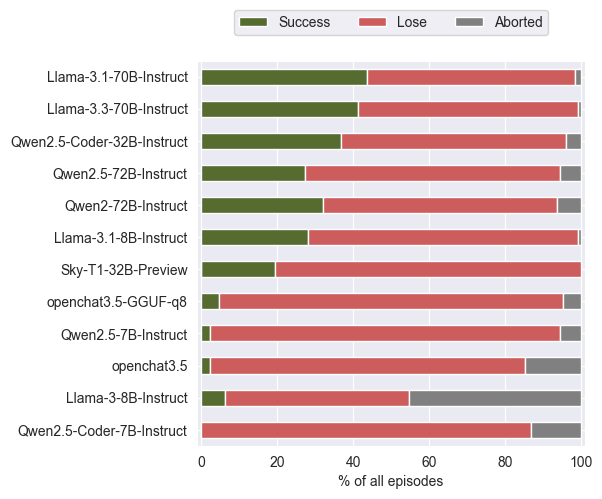

In [11]:
STACK_COLORS = ['darkolivegreen', 'indianred', 'gray']

df_aux = raw_df[raw_df.metric.isin(utils.GAMEPLAY_METRICS)]
df_aux = df_aux.replace(model_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=3)
plt.xlabel('% of all episodes')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

Bar plot with sorted clemscores:

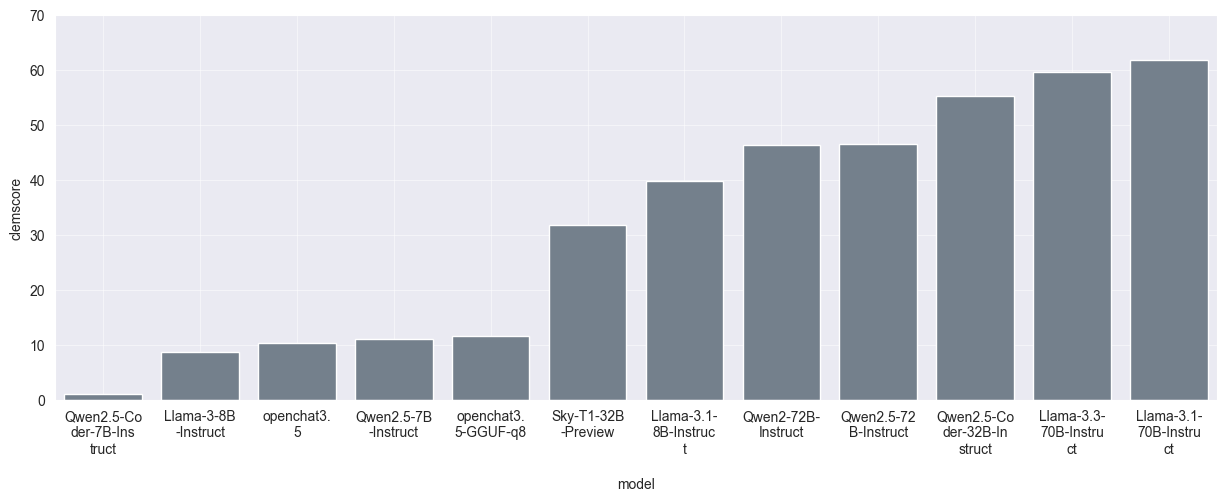

In [12]:
clem_aux = clem_df.sort_values(by='-, clemscore').reset_index(names='model').replace(model_name_dict)
# warning, if models have matching names up the limit, results will be wrongly merged!
clem_aux['model'] = clem_aux['model'].apply(lambda x: f'{x[:10]}\n{x[10:20]}\n{x[20:30]}\n{x[30:]}')

fig = plt.figure(figsize=(15, 5))
sns.barplot(clem_aux, x='model', y='-, clemscore', color='slategray')
# plt.ylim(-5, 105)
plt.ylim(0, 70)
plt.ylabel('clemscore')
plt.grid(alpha=0.5)
plt.show()

Omit models for which all episodes were aborted due to not following prompted format for detail analysis:

In [13]:
all_abort_models = ["LLaMA2-13B-Tiefighter"]
game_df = game_df.query('model not in ["LLaMA2-13B-Tiefighter"]')
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,Parsed Request Count,10.0
2,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,Request Count,10.0
3,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
62971,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_5,Played,1.0
62972,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_6,Played,1.0
62973,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_7,Played,1.0
62974,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_8,Played,1.0


## Failure metrics
### Failures by IF interpreter phase

In [14]:
failures_by_phase_df = game_df.query('metric in ["action_parsing_fail", "action_resolution_fail"]')
failures_by_phase_df

,game,model,experiment,episode,metric,value
5,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,action_parsing_fail,0.0
6,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,action_resolution_fail,0.0
45,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_1,action_parsing_fail,0.0
46,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_1,action_resolution_fail,3.0
85,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_10,action_parsing_fail,0.0
...,...,...,...,...,...,...
61326,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_7,action_resolution_fail,9.0
61365,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_8,action_parsing_fail,47.0
61366,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_8,action_resolution_fail,0.0
61405,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_9,action_parsing_fail,0.0


Bar plot showing failures by phase for all models over all experiments:

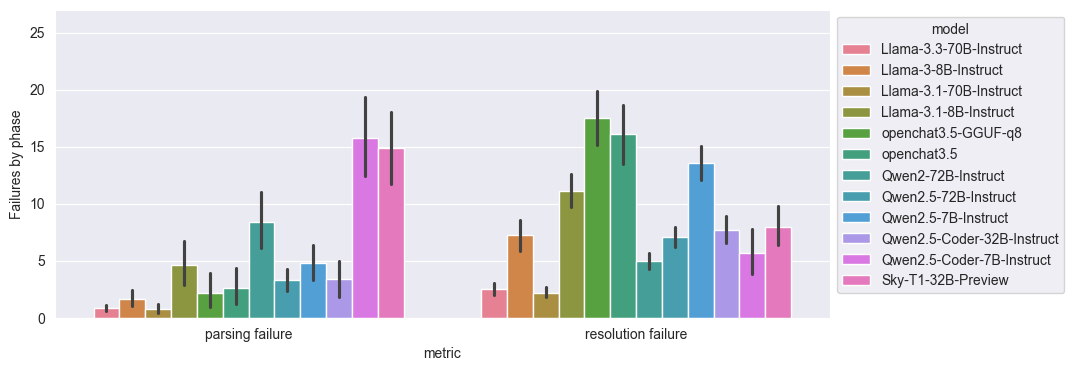

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))

g = sns.barplot(failures_by_phase_df.replace(metric_name_dict),
                x='metric',
                y='value',
                hue='model',
                ax=ax)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.ylim(0, 27)
plt.ylabel("Failures by phase")

plt.show()

Dataframe with parsed request counts, ie actions passed to the IF interpreter (used to calculate failure ratios):

In [16]:
parsed_df = game_df[game_df.metric == "Parsed Request Count"].groupby(["model"]).sum()
parsed_df = parsed_df.drop(columns=["game", 'experiment', 'episode', 'metric'])
parsed_df

,value
model,
Llama-3-8B-Instruct,2683.0
Llama-3.1-70B-Instruct,2975.0
Llama-3.1-8B-Instruct,4905.0
Llama-3.3-70B-Instruct,3026.0
Qwen2-72B-Instruct,4264.0
Qwen2.5-72B-Instruct,4331.0
Qwen2.5-7B-Instruct,5704.0
Qwen2.5-Coder-32B-Instruct,4426.0
Qwen2.5-Coder-7B-Instruct,5540.0


Counts of failures by phase for all models over all experiments:

In [17]:
failures_by_phase_counts = failures_by_phase_df.replace(metric_name_dict).groupby(['model', 'metric']).sum()
failures_by_phase_counts = failures_by_phase_counts.drop(columns=["game", 'experiment', 'episode'])
failures_by_phase_counts

value
model                      metric                    
Llama-3-8B-Instruct        parsing failure      212.0
                           resolution failure   923.0
Llama-3.1-70B-Instruct     parsing failure       94.0
                           resolution failure   282.0
Llama-3.1-8B-Instruct      parsing failure      597.0
                           resolution failure  1426.0
Llama-3.3-70B-Instruct     parsing failure      108.0
                           resolution failure   322.0
Qwen2-72B-Instruct         parsing failure     1078.0
                           resolution failure   636.0
Qwen2.5-72B-Instruct       parsing failure      423.0
                           resolution failure   908.0
Qwen2.5-7B-Instruct        parsing failure      616.0
                           resolution failure  1733.0
Qwen2.5-Coder-32B-Instruct parsing failure      432.0
                           resolution failure   986.0
Qwen2.5-Coder-7B-Instruct  parsing failure     2018.0
                           resolution failure   726.0
Sky-T1-32B-Preview         parsing failure     1900.0
                           resolution failure  1019.0
openchat3.5                parsing failure      338.0
                           resolution failure  2063.0
openchat3.5-GGUF-q8        parsing failure      283.0
                           resolution failure  2243.0

Ratios of failures by phase for all models over all experiments (calculated by dividing failures counts by parsed request counts):

In [18]:
failures_by_phase_ratios = failures_by_phase_counts / parsed_df
failures_by_phase_ratios

value
model                      metric                      
Llama-3-8B-Instruct        parsing failure     0.079016
                           resolution failure  0.344018
Llama-3.1-70B-Instruct     parsing failure     0.031597
                           resolution failure  0.094790
Llama-3.1-8B-Instruct      parsing failure     0.121713
                           resolution failure  0.290724
Llama-3.3-70B-Instruct     parsing failure     0.035691
                           resolution failure  0.106411
Qwen2-72B-Instruct         parsing failure     0.252814
                           resolution failure  0.149156
Qwen2.5-72B-Instruct       parsing failure     0.097668
                           resolution failure  0.209651
Qwen2.5-7B-Instruct        parsing failure     0.107994
                           resolution failure  0.303822
Qwen2.5-Coder-32B-Instruct parsing failure     0.097605
                           resolution failure  0.222775
Qwen2.5-Coder-7B-Instruct  parsing failure     0.364260
                           resolution failure  0.131047
Sky-T1-32B-Preview         parsing failure     0.334507
                           resolution failure  0.179401
openchat3.5                parsing failure     0.078843
                           resolution failure  0.481222
openchat3.5-GGUF-q8        parsing failure     0.063368
                           resolution failure  0.502239

Overview/model comparison stacked bar plot for successful actions and failures by phase:

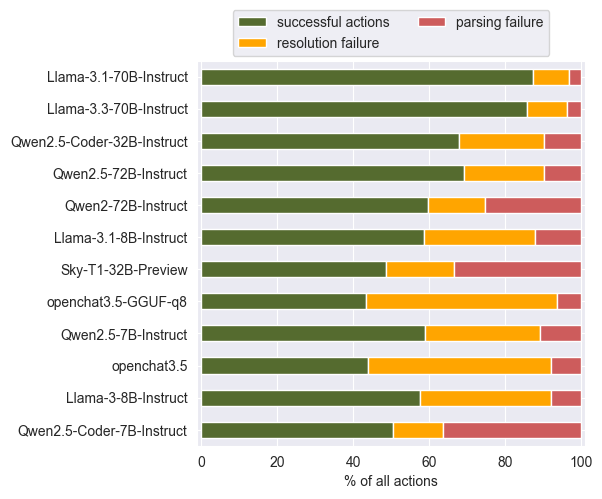

In [19]:
STACK_COLORS = ['darkolivegreen', 'orange', 'indianred']

phase_failures = ["action_parsing_fail", "action_resolution_fail", "successful_actions"]

df_aux = game_df[game_df.metric.isin(phase_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of all actions')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

### Parsing failures
Dataframe with parsing failure counts/ratios:
Note: While "undefined_action" and "undefined_argument_type" did not occur in the v1 results, they are implemented, and thus not omitted here.

In [20]:
parsing_failures_df = game_df.query('metric in ["lark_exception", "malformed_command", "undefined_action", "undefined_action_verb", "undefined_repr_str", "undefined_argument_type"]')
parsing_failures_df = parsing_failures_df.replace(metric_name_dict)
parsing_failures_counts = parsing_failures_df.groupby(['model', 'metric']).sum()
parsing_failures_counts = parsing_failures_counts.drop(columns=["game", 'experiment', 'episode'])
parsing_failures_counts['Ratio'] = parsing_failures_counts / parsed_df
parsing_failures_counts = parsing_failures_counts.rename(columns={"value": "Count"})
parsing_failures_counts

Count     Ratio
model               metric                                
Llama-3-8B-Instruct malformed command       60.0  0.022363
                    out of grammar          12.0  0.004473
                    undefined action type    0.0  0.000000
                    undefined action verb   73.0  0.027208
                    undefined antecedent     0.0  0.000000
...                                          ...       ...
openchat3.5-GGUF-q8 out of grammar           0.0  0.000000
                    undefined action type    0.0  0.000000
                    undefined action verb   97.0  0.021720
                    undefined antecedent     0.0  0.000000
                    undefined noun         129.0  0.028885

[72 rows x 2 columns]

In [21]:
parsing_failures_counts.style.format(subset="Count", precision=0).format(subset="Ratio", precision=3).to_latex('results/parsing_failures_table.tex', clines="skip-last;data")

Overview/model comparison stacked bar plot for parsing failures:
Note: Non-occurring parsing failure types are omitted here.

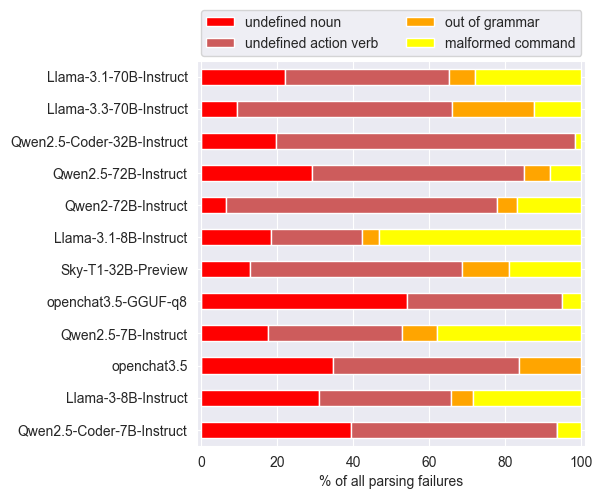

In [22]:
STACK_COLORS = ['red', 'indianred', 'orange', 'yellow']

parse_failures = ["lark_exception", "malformed_command", "undefined_action_verb", "undefined_repr_str"]

df_aux = game_df[game_df.metric.isin(parse_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of all parsing failures')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

### Room/navigation failures
Dataframe with room/navigation failure counts/ratios:
Note: While "thing_arg1_room" and "thing_arg2_room" did not occur in the v1 results, they are implemented, and thus not omitted here.

In [23]:
room_failures_df = game_df.query('metric in ["not_room_type", "no_exit_to", "manipulating_room", "other_room_argument", "thing_arg1_room", "thing_arg2_room"]')
room_failures_df = room_failures_df.replace(metric_name_dict)
room_failures_counts = room_failures_df.groupby(['model', 'metric']).sum()
room_failures_counts = room_failures_counts.drop(columns=["game", 'experiment', 'episode'])
room_failures_counts['ratio'] = room_failures_counts / parsed_df
room_failures_counts

value     ratio
model                      metric                                      
Llama-3-8B-Instruct        going to non-adjacent room   130.0  0.048453
                           interacting with other room    2.0  0.000745
                           manipulating room              0.0  0.000000
Llama-3.1-70B-Instruct     going to non-adjacent room   131.0  0.044034
                           interacting with other room    7.0  0.002353
                           manipulating room              0.0  0.000000
Llama-3.1-8B-Instruct      going to non-adjacent room   326.0  0.066463
                           interacting with other room   23.0  0.004689
                           manipulating room              0.0  0.000000
Llama-3.3-70B-Instruct     going to non-adjacent room   176.0  0.058163
                           interacting with other room    2.0  0.000661
                           manipulating room              0.0  0.000000
Qwen2-72B-Instruct         going to non-adjacent room   315.0  0.073874
                           interacting with other room   19.0  0.004456
                           manipulating room              0.0  0.000000
Qwen2.5-72B-Instruct       going to non-adjacent room   359.0  0.082891
                           interacting with other room    2.0  0.000462
                           manipulating room              0.0  0.000000
Qwen2.5-7B-Instruct        going to non-adjacent room   420.0  0.073633
                           interacting with other room   35.0  0.006136
                           manipulating room              8.0  0.001403
Qwen2.5-Coder-32B-Instruct going to non-adjacent room   410.0  0.092634
                           interacting with other room    0.0  0.000000
                           manipulating room              0.0  0.000000
Qwen2.5-Coder-7B-Instruct  going to non-adjacent room    41.0  0.007401
                           interacting with other room    0.0  0.000000
                           manipulating room              0.0  0.000000
Sky-T1-32B-Preview         going to non-adjacent room   312.0  0.054930
                           interacting with other room    0.0  0.000000
                           manipulating room              2.0  0.000352
openchat3.5                going to non-adjacent room   422.0  0.098437
                           interacting with other room    2.0  0.000467
                           manipulating room             52.0  0.012130
openchat3.5-GGUF-q8        going to non-adjacent room   245.0  0.054859
                           interacting with other room   17.0  0.003807
                           manipulating room             27.0  0.006046

Overview/model comparison stacked bar plot for room/navigation failures:
Note: Non-occurring room/navigation failure types are omitted here.

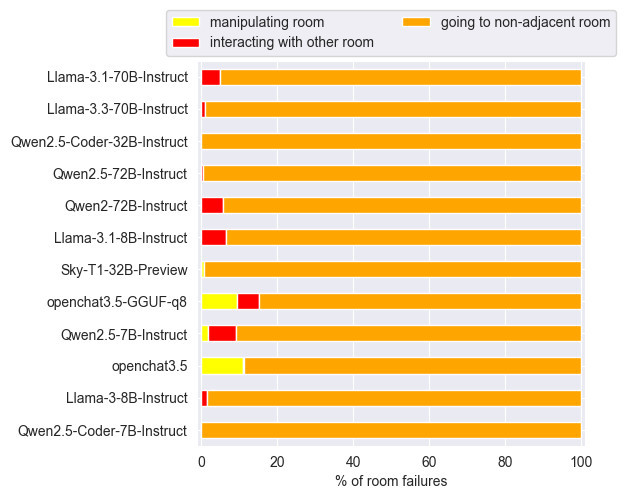

In [24]:
STACK_COLORS = ['yellow', 'orange', 'indianred', 'red', 'yellow', 'orange']

room_failures = ["not_room_type", "no_exit_to", "manipulating_room", "other_room_argument"]

df_aux = game_df[game_df.metric.isin(room_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of room failures')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

### Entity-related failures
Dataframe with entity-related failure counts/ratios:

In [25]:
entity_failures_df = game_df.query('metric in ["entity_not_accessible", "entity_already_inventory", "entity_state_mismatch", "entity_trait_mismatch", "inventory_limit_exceeded"]')
entity_failures_df = entity_failures_df.replace(metric_name_dict)
entity_failures_counts = entity_failures_df.groupby(['model', 'metric']).sum()
entity_failures_counts = entity_failures_counts.drop(columns=["game", 'experiment', 'episode'])
entity_failures_counts['ratio'] = entity_failures_counts / parsed_df
entity_failures_counts

value     ratio
model                      metric                                       
Llama-3-8B-Instruct        entity already in inventory     4.0  0.001491
                           entity not accessible         595.0  0.221767
                           entity state mismatch           5.0  0.001864
                           entity trait mismatch           0.0  0.000000
                           inventory limit exceeded       18.0  0.006709
Llama-3.1-70B-Instruct     entity already in inventory     5.0  0.001681
                           entity not accessible          97.0  0.032605
                           entity state mismatch           1.0  0.000336
                           entity trait mismatch           0.0  0.000000
                           inventory limit exceeded       20.0  0.006723
Llama-3.1-8B-Instruct      entity already in inventory    14.0  0.002854
                           entity not accessible         768.0  0.156575
                           entity state mismatch          29.0  0.005912
                           entity trait mismatch           0.0  0.000000
                           inventory limit exceeded       34.0  0.006932
Llama-3.3-70B-Instruct     entity already in inventory    11.0  0.003635
                           entity not accessible         107.0  0.035360
                           entity state mismatch           2.0  0.000661
                           entity trait mismatch           0.0  0.000000
                           inventory limit exceeded       16.0  0.005288
Qwen2-72B-Instruct         entity already in inventory    46.0  0.010788
                           entity not accessible         190.0  0.044559
                           entity state mismatch           6.0  0.001407
                           entity trait mismatch           0.0  0.000000
                           inventory limit exceeded        9.0  0.002111
Qwen2.5-72B-Instruct       entity already in inventory    47.0  0.010852
                           entity not accessible         227.0  0.052413
                           entity state mismatch           7.0  0.001616
                           entity trait mismatch           0.0  0.000000
                           inventory limit exceeded        4.0  0.000924
Qwen2.5-7B-Instruct        entity already in inventory    25.0  0.004383
                           entity not accessible         696.0  0.122020
                           entity state mismatch         177.0  0.031031
                           entity trait mismatch           0.0  0.000000
                           inventory limit exceeded       59.0  0.010344
Qwen2.5-Coder-32B-Instruct entity already in inventory    16.0  0.003615
                           entity not accessible         302.0  0.068233
                           entity state mismatch           6.0  0.001356
                           entity trait mismatch           0.0  0.000000
                           inventory limit exceeded       10.0  0.002259
Qwen2.5-Coder-7B-Instruct  entity already in inventory     1.0  0.000181
                           entity not accessible         309.0  0.055776
                           entity state mismatch         180.0  0.032491
                           entity trait mismatch           0.0  0.000000
                           inventory limit exceeded       18.0  0.003249
Sky-T1-32B-Preview         entity already in inventory     9.0  0.001585
                           entity not accessible         201.0  0.035387
                           entity state mismatch          20.0  0.003521
                           entity trait mismatch           0.0  0.000000
                           inventory limit exceeded      102.0  0.017958
openchat3.5                entity already in inventory    31.0  0.007231
                           entity not accessible        1186.0  0.276650
                           entity state mismatch          55.0  0.012829
                           entity trait mi

Overview/model comparison stacked bar plot for entity-related failures:

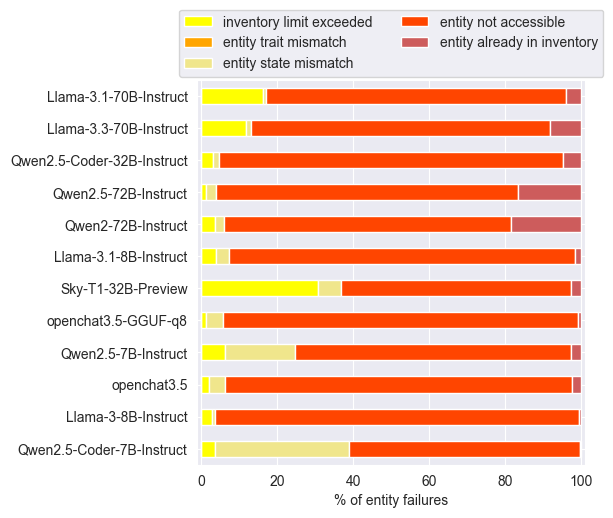

In [26]:
STACK_COLORS = ['yellow', 'orange', 'red', 'khaki', 'orangered', 'indianred']

entity_failures = ["entity_not_accessible", "entity_already_inventory", "entity_state_mismatch", "entity_trait_mismatch", "inventory_limit_exceeded"]

df_aux = game_df[game_df.metric.isin(entity_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncols=2)
plt.xlabel('% of entity failures')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

## Overview tables
Dispersion metrics over all episodes. Note that this uses groupby, which will ignore NaN values, according to the clembench documentation!

In [27]:
stats_df = build_dispersion_table(['game', 'model', 'metric'], game_df) # could also use raw_df for results for all games
stats_df

mean  \
game          model               metric                               
adventuregame Llama-3-8B-Instruct Aborted                   0.453125   
                                  Lose                      0.484375   
                                  Main Score               16.145833   
                                  Parsed Request Count     20.960938   
                                  Played                    0.546875   
...                                                              ...   
              openchat3.5-GGUF-q8 undefined_action          0.000000   
                                  undefined_action_verb     0.757812   
                                  undefined_argument_type   0.000000   
                                  undefined_repr_str        1.007812   
                                  world_state_discrepancy   0.000000   

                                                                 std  \
game          model               metric                               
adventuregame Llama-3-8B-Instruct Aborted                   0.499754   
                                  Lose                      0.501719   
                                  Main Score               29.573928   
                                  Parsed Request Count     17.060062   
                                  Played                    0.499754   
...                                                              ...   
              openchat3.5-GGUF-q8 undefined_action          0.000000   
                                  undefined_action_verb     4.830588   
                                  undefined_argument_type   0.000000   
                                  undefined_repr_str        6.080168   
                                  world_state_discrepancy   0.000000   

                                                                  var  median  \
game          model               metric                                        
adventuregame Llama-3-8B-Instruct Aborted                    0.249754     0.0   
                                  Lose                       0.251722     0.0   
                                  Main Score               874.617235     0.0   
                                  Parsed Request Count     291.045706    17.0   
                                  Played                     0.249754     1.0   
...                                                               ...     ...   
              openchat3.5-GGUF-q8 undefined_action           0.000000     0.0   
                                  undefined_action_verb     23.334584     0.0   
                                  undefined_argument_type    0.000000     0.0   
                                  undefined_repr_str        36.968442     0.0   
                                  world_state_discrepancy    0.000000     0.0   

                                                             max  min  \
game          model               metric                                
adventuregame Llama-3-8B-Instruct Aborted                    1.0  0.0   
                                  Lose                       1.0  0.0   
                                  Main Score               100.0  0.0   
                                  Parsed Request Count      50.0  1.0   
                                  Played                     1.0  0.0   
...                                                          ...  ...   
              openchat3.5-GGUF-q8 undefined_action           0.0  0.0   
                                  undefined_action_verb     42.0  0.0   
                                  undefined_argument_type    0.0  0.0   
                                  undefined_repr_str        44.0  0.0   
                                  world_state_discrepancy    0.0  0.0   

                                                               skew  
game          model               metric                             
adventuregame Llama-3-8B-Instruct Aborted     

In [28]:
failure_stats_by_phase_df = stats_df.query('metric in ["action_parsing_fail", "action_resolution_fail"]')
failure_stats_by_phase_df

mean  \
game          model                      metric                              
adventuregame Llama-3-8B-Instruct        action_parsing_fail      1.656250   
                                         action_resolution_fail   7.210938   
              Llama-3.1-70B-Instruct     action_parsing_fail      0.734375   
                                         action_resolution_fail   2.203125   
              Llama-3.1-8B-Instruct      action_parsing_fail      4.664062   
                                         action_resolution_fail  11.140625   
              Llama-3.3-70B-Instruct     action_parsing_fail      0.843750   
                                         action_resolution_fail   2.515625   
              Qwen2-72B-Instruct         action_parsing_fail      8.421875   
                                         action_resolution_fail   4.968750   
              Qwen2.5-72B-Instruct       action_parsing_fail      3.304688   
                                         action_resolution_fail   7.093750   
              Qwen2.5-7B-Instruct        action_parsing_fail      4.812500   
                                         action_resolution_fail  13.539062   
              Qwen2.5-Coder-32B-Instruct action_parsing_fail      3.375000   
                                         action_resolution_fail   7.703125   
              Qwen2.5-Coder-7B-Instruct  action_parsing_fail     15.765625   
                                         action_resolution_fail   5.671875   
              Sky-T1-32B-Preview         action_parsing_fail     14.843750   
                                         action_resolution_fail   7.960938   
              openchat3.5                action_parsing_fail      2.640625   
                                         action_resolution_fail  16.117188   
              openchat3.5-GGUF-q8        action_parsing_fail      2.210938   
                                         action_resolution_fail  17.523438   

                                                                       std  \
game          model                      metric                              
adventuregame Llama-3-8B-Instruct        action_parsing_fail      4.249016   
                                         action_resolution_fail   8.121763   
              Llama-3.1-70B-Instruct     action_parsing_fail      2.473432   
                                         action_resolution_fail   2.639373   
              Llama-3.1-8B-Instruct      action_parsing_fail     11.107405   
                                         action_resolution_fail   8.545141   
              Llama-3.3-70B-Instruct     action_parsing_fail      1.411078   
                                         action_resolution_fail   3.169700   
              Qwen2-72B-Instruct         action_parsing_fail     13.520244   
                                         action_resolution_fail   4.272117   
              Qwen2.5-72B-Instruct       action_parsing_fail      5.751492   
                                         action_resolution_fail   5.193026   
              Qwen2.5-7B-Instruct        action_parsing_fail      9.209504   
                                         action_resolution_fail   8.980208   
              Qwen2.5-Coder-32B-Instruct action_parsing_fail      9.332021   
                                         action_resolution_fail   7.390523   
              Qwen2.5-Coder-7B-Instruct  action_parsing_fail     21.302281   
                                         action_resolution_fail  11.474799   
              Sky-T1-32B-Preview         action_parsing_fail     17.391480   
                                         action_resolution_fail   9.637037   
              openchat3.5                action_parsing_fail      9.376411   
                                         action_resolution_fail  14.847053   
              openchat3.5-GGUF-q8        action_parsing_fail      8.501646   
                                         action_resolution_fail  14.814318   

            

Break results down by experiment:

In [29]:
detailed_stats_df = build_dispersion_table(['game', 'model', 'experiment', 'metric'], game_df) # could also use raw_df for results for all games
detailed_stats_df

mean  \
game          model               experiment             metric                               
adventuregame Llama-3-8B-Instruct basic-easy             Aborted                   0.000000   
                                                         Lose                      0.812500   
                                                         Main Score               22.916667   
                                                         Parsed Request Count     31.750000   
                                                         Played                    1.000000   
...                                                                                     ...   
              openchat3.5-GGUF-q8 planning-hard-invlimit undefined_action          0.000000   
                                                         undefined_action_verb     0.312500   
                                                         undefined_argument_type   0.000000   
                                                         undefined_repr_str        5.437500   
                                                         world_state_discrepancy   0.000000   

                                                                                        std  \
game          model               experiment             metric                               
adventuregame Llama-3-8B-Instruct basic-easy             Aborted                   0.000000   
                                                         Lose                      0.403113   
                                                         Main Score               41.666667   
                                                         Parsed Request Count     14.612780   
                                                         Played                    0.000000   
...                                                                                     ...   
              openchat3.5-GGUF-q8 planning-hard-invlimit undefined_action          0.000000   
                                                         undefined_action_verb     0.793200   
                                                         undefined_argument_type   0.000000   
                                                         undefined_repr_str       14.859200   
                                                         world_state_discrepancy   0.000000   

                                                                                          var  \
game          model               experiment             metric                                 
adventuregame Llama-3-8B-Instruct basic-easy             Aborted                     0.000000   
                                                         Lose                        0.162500   
                                                         Main Score               1736.111111   
                                                         Parsed Request Count      213.533333   
                                                         Played                      0.000000   
...                                                                                       ...   
              openchat3.5-GGUF-q8 planning-hard-invlimit undefined_action            0.000000   
                                                         undefined_action_verb       0.629167   
                                                         undefined_argument_type     0.000000   
                                                         undefined_repr_str        220.795833   
                                                         world_state_discrepancy     0.000000   

                                                                                  median  \
game          model               experiment             metric                            
adventuregame Llama-3-8B-Instruct basic-easy             Aborted                     0.0   
                                                         Lose                

In [30]:
stats_df.to_csv('results/adventuregame_stats.csv')
detailed_stats_df.to_csv('results/adventuregame_stats_detailed.csv')

In [31]:
stats_df.to_html('results/adventuregame_stats.html')
detailed_stats_df.to_html('results/adventuregame_stats_detailed.html')

Condensed tables:

In [32]:
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,Parsed Request Count,10.0
2,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,Request Count,10.0
3,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
62971,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_5,Played,1.0
62972,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_6,Played,1.0
62973,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_7,Played,1.0
62974,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_8,Played,1.0


In [33]:
selected_stats_df = game_df.drop(columns=["game"])
selected_metrics_list = ["Main Score", "Played", "Success", "action_parsing_fail", "action_resolution_fail", "successful_actions"]
selected_stats_df = selected_stats_df.query('metric in ["Main Score", "Played"]')
selected_stats_df = build_dispersion_table(['model', 'experiment', 'metric'], selected_stats_df)
selected_stats_df = selected_stats_df.drop(columns=["var", "median", "max", "min", "skew"])
selected_stats_df = selected_stats_df.rename(metric_name_dict)
selected_stats_df = selected_stats_df.rename({"Main Score": "Score"})
selected_stats_df = selected_stats_df.reset_index()
selected_stats_df = pd.pivot_table(selected_stats_df, index=['model', 'experiment'], columns='metric')
selected_stats_df

mean                  std  \
metric                                      Played      Score    Played   
model               experiment                                            
Llama-3-8B-Instruct basic-easy              1.0000  22.916667  0.000000   
                    basic-easy-invlimit     1.0000  33.333333  0.000000   
                    basic-hard              0.9375  14.583333  0.250000   
                    basic-hard-invlimit     1.0000  20.833333  0.000000   
                    planning-easy           0.0000  12.500000  0.000000   
...                                            ...        ...       ...   
openchat3.5-GGUF-q8 basic-hard-invlimit     1.0000   2.083333  0.000000   
                    planning-easy           1.0000  16.666667  0.000000   
                    planning-easy-invlimit  0.8750  14.583333  0.341565   
                    planning-hard           0.8750   2.083333  0.341565   
                    planning-hard-invlimit  0.8750   2.083333  0.341565   

                                                       
metric                                          Score  
model               experiment                         
Llama-3-8B-Instruct basic-easy              41.666667  
                    basic-easy-invlimit     45.542003  
                    basic-hard              17.078251  
                    basic-hard-invlimit     23.959843  
                    planning-easy           23.959843  
...                                               ...  
openchat3.5-GGUF-q8 basic-hard-invlimit      8.333333  
                    planning-easy           29.814240  
                    planning-easy-invlimit  27.131368  
                    planning-hard            8.333333  
                    planning-hard-invlimit   8.333333  

[96 rows x 4 columns]

In [34]:
selected_stats_df.to_html("results/selected_stats.html")

In [35]:
selected_stats_styled = selected_stats_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(precision=2)
selected_stats_styled.to_latex("results/selected_stats.tex", clines="skip-last;data")

Planning variant:

In [36]:
plan_df = game_df.query('experiment in ["planning-easy", "planning-hard", "planning-easy-invlimit", "planning-hard-invlimit"]')
plan_df

,game,model,experiment,episode,metric,value
640,adventuregame,Llama-3.3-70B-Instruct,planning-easy,episode_0,Violated Request Count,0.0
641,adventuregame,Llama-3.3-70B-Instruct,planning-easy,episode_0,Parsed Request Count,10.0
642,adventuregame,Llama-3.3-70B-Instruct,planning-easy,episode_0,Request Count,10.0
643,adventuregame,Llama-3.3-70B-Instruct,planning-easy,episode_0,Request Success Ratio,1.0
644,adventuregame,Llama-3.3-70B-Instruct,planning-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
62971,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_5,Played,1.0
62972,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_6,Played,1.0
62973,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_7,Played,1.0
62974,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_8,Played,1.0


In [37]:
selected_plan_df = plan_df.drop(columns=["game"])
selected_plan_df = selected_plan_df.query('metric in ["plan_average_viability_ratio", "plan_followed_ratio", "bad_plan_dismiss_ratio"]')

selected_plan_df = build_dispersion_table(['model', 'experiment', 'metric'], selected_plan_df)
selected_plan_df = selected_plan_df.drop(columns=["var", "median", "max", "min", "skew"])

selected_plan_df = selected_plan_df.rename(metric_name_dict)
selected_plan_df = selected_plan_df.rename({"plan_average_viability_ratio": "Viable", "plan_followed_ratio": "Follow", "bad_plan_dismiss_ratio": "Adapt"})

selected_plan_df = selected_plan_df.reset_index()
selected_plan_df = pd.pivot_table(selected_plan_df, index=['model', 'experiment'], columns='metric')

selected_plan_df

mean            \
metric                                                Adapt    Follow   
model                      experiment                                   
Llama-3-8B-Instruct        planning-easy           0.902741  0.200874   
                           planning-easy-invlimit  0.814107  0.305537   
                           planning-hard           0.905722  0.204129   
                           planning-hard-invlimit  0.891443  0.157664   
Llama-3.1-70B-Instruct     planning-easy           0.977766  0.497133   
                           planning-easy-invlimit  0.973824  0.525467   
                           planning-hard           0.961666  0.193996   
                           planning-hard-invlimit  0.915908  0.430059   
Llama-3.1-8B-Instruct      planning-easy           0.912069  0.284543   
                           planning-easy-invlimit  0.899165  0.323332   
                           planning-hard           0.913928  0.170079   
                           planning-hard-invlimit  0.910285  0.220032   
Llama-3.3-70B-Instruct     planning-easy           0.981816  0.330280   
                           planning-easy-invlimit  0.967121  0.387470   
                           planning-hard           0.972894  0.132146   
                           planning-hard-invlimit  0.961149  0.135600   
Qwen2-72B-Instruct         planning-easy           0.953907  0.212226   
                           planning-easy-invlimit  0.941056  0.269283   
                           planning-hard           0.975380  0.054022   
                           planning-hard-invlimit  0.984211  0.056900   
Qwen2.5-72B-Instruct       planning-easy           0.895092  0.369087   
                           planning-easy-invlimit  0.926406  0.285780   
                           planning-hard           0.943051  0.169166   
                           planning-hard-invlimit  0.927334  0.214201   
Qwen2.5-7B-Instruct        planning-easy           0.865469  0.279401   
                           planning-easy-invlimit  0.925278  0.175833   
                           planning-hard           0.907321  0.213929   
                           planning-hard-invlimit  0.917500  0.217744   
Qwen2.5-Coder-32B-Instruct planning-easy           0.907316  0.349043   
                           planning-easy-invlimit  0.862587  0.456621   
                           planning-hard           0.950866  0.162787   
                           planning-hard-invlimit  0.900759  0.221177   
Qwen2.5-Coder-7B-Instruct  planning-easy           0.972500  0.036250   
                           planning-easy-invlimit  0.861845  0.140655   
                           planning-hard           0.985000  0.018750   
                           planning-hard-invlimit  0.997500  0.022500   
Sky-T1-32B-Preview         planning-easy           0.992283  0.031267   
                           planning-easy-invlimit  0.980951  0.061166   
                           planning-hard           0.998670  0.005926   
                           planning-hard-invlimit  0.998750  0.006667   
openchat3.5                planning-easy           0.900385  0.147212   
                           planning-easy-invlimit  0.812857  0.222455   
                           planning-hard           0.871181  0.187569   
                           planning-hard-invlimit  0.832500  0.231042   
openchat3.5-GGUF-q8        planning-easy           0.791684  0.287284   
                           planning-easy-invlimit  0.860595  0.202321   
                           planning-hard           0.857113  0.218199   
                           planning-hard-invlimit  0.747708  0.335833   

                                                                  std  \
metric                                               Viable     Adapt   
model                      experiment                                   
Llama-3-8B-Instruct        planning-easy           0.164664  0.099690   
                           planning-eas

In [38]:
selected_plan_styled = selected_plan_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(precision=2)
selected_plan_styled.to_latex("results/selected_planning.tex", clines="skip-last;data")

Hallucinations:

In [39]:
hallucination_df = game_df[game_df.metric == 'hallucination_count']
hallucination_df

,game,model,experiment,episode,metric,value
4,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,hallucination_count,0.0
44,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_1,hallucination_count,0.0
84,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_10,hallucination_count,1.0
124,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_11,hallucination_count,1.0
164,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_12,hallucination_count,1.0
...,...,...,...,...,...,...
61244,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_5,hallucination_count,1.0
61284,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_6,hallucination_count,0.0
61324,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_7,hallucination_count,0.0
61364,adventuregame,Sky-T1-32B-Preview,planning-hard-invlimit,episode_8,hallucination_count,0.0


In [40]:
llama3_1_70b_hallu = hallucination_df.query('model == "Llama-3.1-70b-Instruct" and value == 1')
llama3_1_70b_hallu

,game,model,experiment,episode,metric,value


In [41]:
hallucination_counts = hallucination_df.groupby(['model']).sum()
hallucination_sums = hallucination_counts.iloc[0:14, [4]]
# hallucination_sums['Ratio'] = hallucination_sums.value / 64
hallucination_sums['Ratio'] = hallucination_sums.value / 128
hallucination_sums = hallucination_sums.rename(columns = {"value": "Total"})
hallucination_sums

,Total,Ratio
model,,
Llama-3-8B-Instruct,46.0,0.359375
Llama-3.1-70B-Instruct,65.0,0.507812
Llama-3.1-8B-Instruct,23.0,0.179688
Llama-3.3-70B-Instruct,71.0,0.554688
Qwen2-72B-Instruct,42.0,0.328125
Qwen2.5-72B-Instruct,49.0,0.382812
Qwen2.5-7B-Instruct,17.0,0.132812
Qwen2.5-Coder-32B-Instruct,34.0,0.265625
Qwen2.5-Coder-7B-Instruct,2.0,0.015625


In [42]:
hallucination_sums.to_html('results/hallucination_sums.html')

In [43]:
h_styled = hallucination_sums.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(subset="Ratio", precision=3).format(subset="Total", precision=0)
h_styled.to_latex('results/hallucination_sums.tex')

In [44]:
h_styled = hallucination_sums.style.format(subset="Ratio", precision=3).format(subset="Total", precision=0).to_latex('results/hallucination_sums.tex', clines="skip-last;data")

In [45]:
detailed_hallucination_df = build_dispersion_table(['model'], hallucination_df)
detailed_hallucination_df

,mean,std,var,median,max,min,skew
model,,,,,,,
Llama-3-8B-Instruct,0.359375,0.481703,0.232037,0.0,1.0,0.0,0.593134
Llama-3.1-70B-Instruct,0.507812,0.501903,0.251907,1.0,1.0,0.0,-0.031626
Llama-3.1-8B-Instruct,0.179688,0.385436,0.148561,0.0,1.0,0.0,1.688463
Llama-3.3-70B-Instruct,0.554688,0.498953,0.248954,1.0,1.0,0.0,-0.222688
Qwen2-72B-Instruct,0.328125,0.471376,0.222195,0.0,1.0,0.0,0.740824
Qwen2.5-72B-Instruct,0.382812,0.487983,0.238127,0.0,1.0,0.0,0.487917
Qwen2.5-7B-Instruct,0.132812,0.340705,0.116080,0.0,1.0,0.0,2.189668
Qwen2.5-Coder-32B-Instruct,0.265625,0.443401,0.196604,0.0,1.0,0.0,1.073950
Qwen2.5-Coder-7B-Instruct,0.015625,0.124507,0.015502,0.0,1.0,0.0,7.904196


## Specific metrics plots
Bar plot overview by model and experiment:

In [46]:
def metric_bar_plot(source_df, metric, max_value=1):
    metric_df = source_df[game_df.metric == metric].sort_values('experiment')
    fig, ax = plt.subplots(figsize=(14, 4))

    g = sns.barplot(metric_df,
                x='experiment',
                y='value',
                hue='model', 
                ax=ax)

    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    plt.ylim(0, max_value)
    plt.ylabel(metric)

    plt.show()

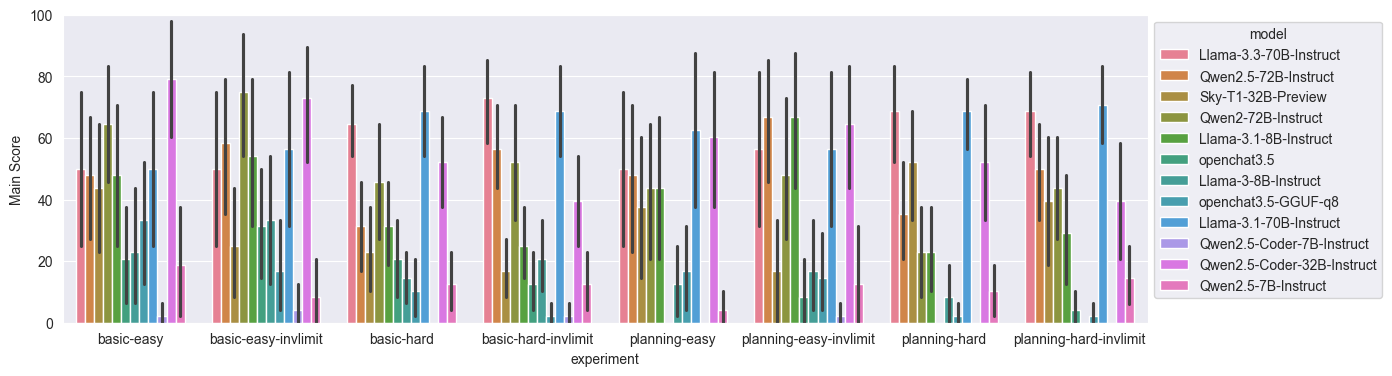

In [47]:
metric_bar_plot(game_df, "Main Score", max_value=100)

Planning:

C:\Users\JJ\AppData\Local\Temp\ipykernel_17944\8844963.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


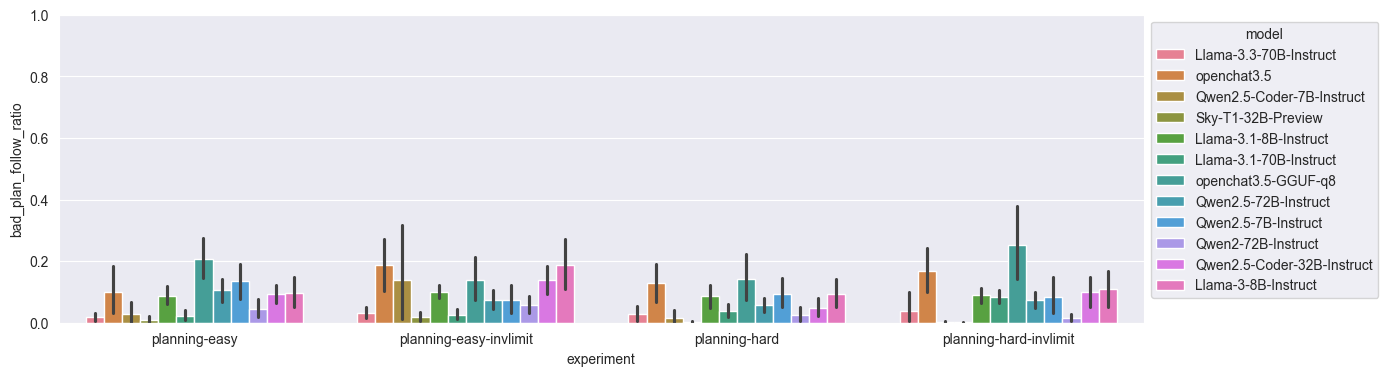

In [48]:
metric_bar_plot(plan_df, "bad_plan_follow_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_17944\8844963.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


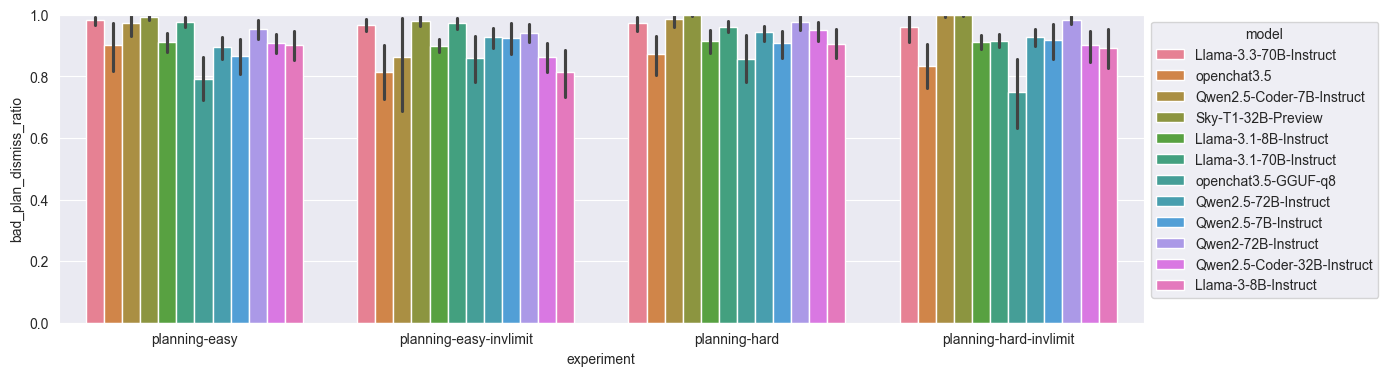

In [49]:
metric_bar_plot(plan_df, "bad_plan_dismiss_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_17944\8844963.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


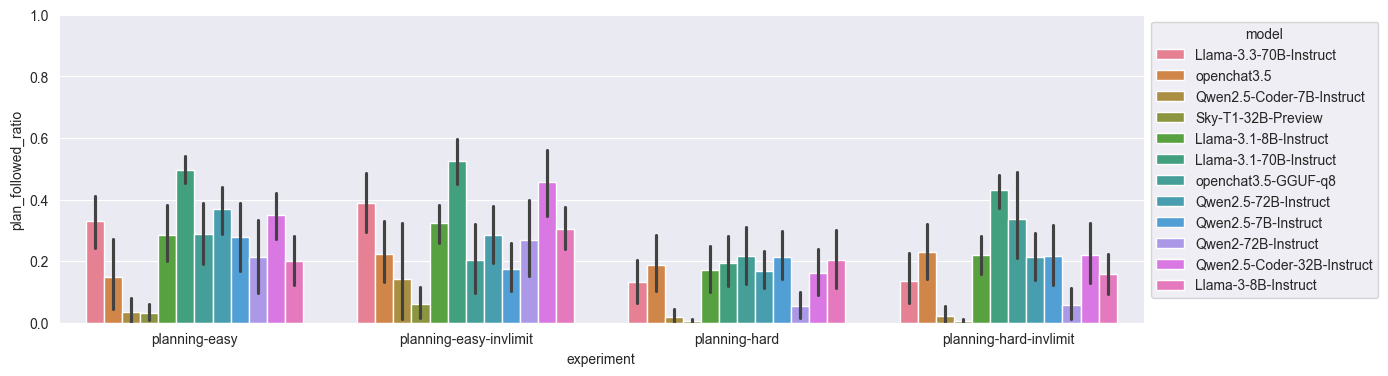

In [50]:
metric_bar_plot(plan_df, "plan_followed_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_17944\8844963.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


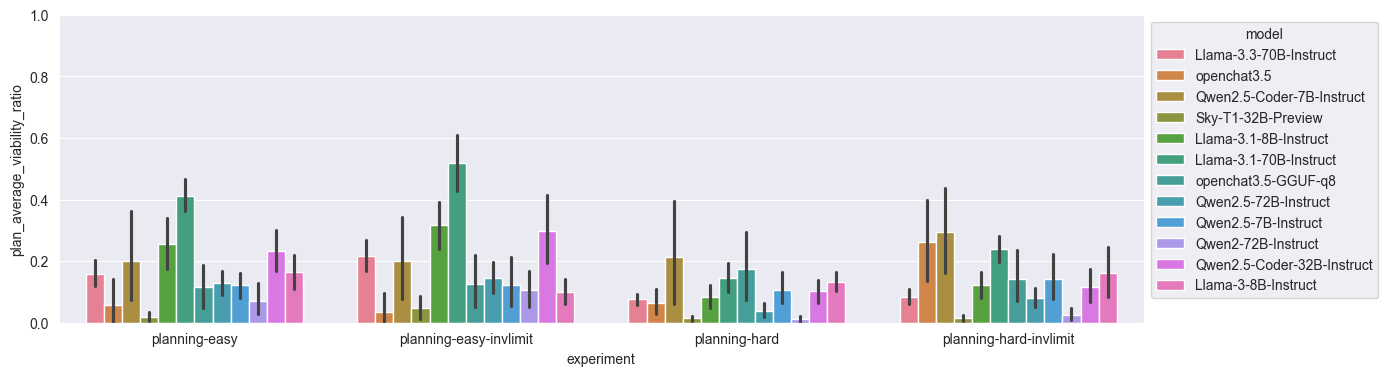

In [51]:
metric_bar_plot(plan_df, "plan_average_viability_ratio")

## Exploration

In [52]:
# get single episode for exploration line plot
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "0_home_deliver_three_basic_easy"
episode = "episode_0"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
turn_scores = scores['turn scores']
turns_known_entities_ratio = [score_values['known_entities_ratio'] for score_values in turn_scores.values()]
turns_known_entities_ratio

[0.13793103448275862,
 0.13793103448275862,
 0.1724137931034483,
 0.27586206896551724,
 0.27586206896551724,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552]

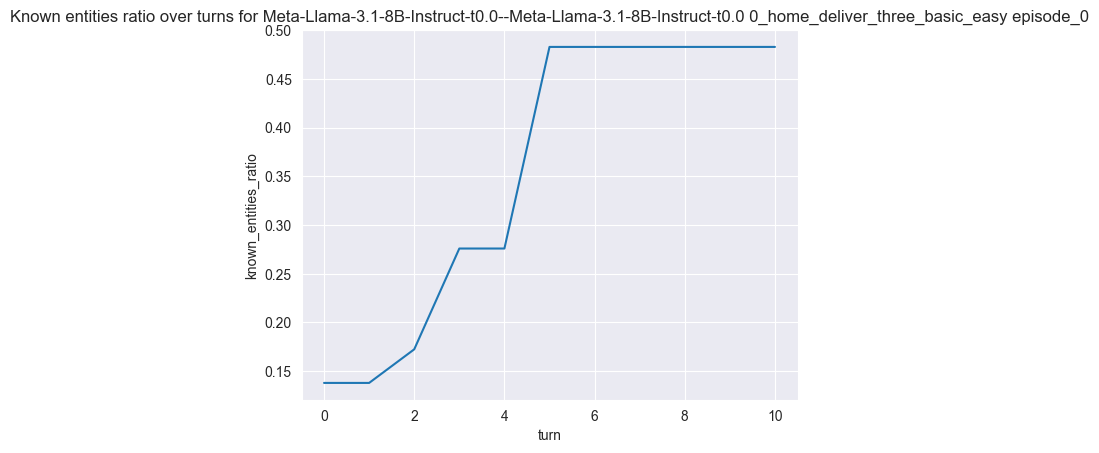

In [53]:
fig, ax = plt.subplots()
ax.plot(turns_known_entities_ratio)

ax.set(xlabel='turn', ylabel='known_entities_ratio',
       title=f'Known entities ratio over turns for {model_id} {variant} {episode}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

In [54]:
# get single episode for exploration line plot
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "1_home_deliver_three_planning_easy"
episode = "episode_0"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
turn_scores = scores['turn scores']
turns_plan_command_success_ratio = [score_values['plan_command_success_ratio'] for score_values in turn_scores.values()]
turns_known_entities_ratio = [score_values['known_entities_ratio'] for score_values in turn_scores.values()]
turns_known_goal_entities_ratio = [score_values['known_goal_entities_ratio'] for score_values in turn_scores.values()]
turns_plan_command_success_ratio

[0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]

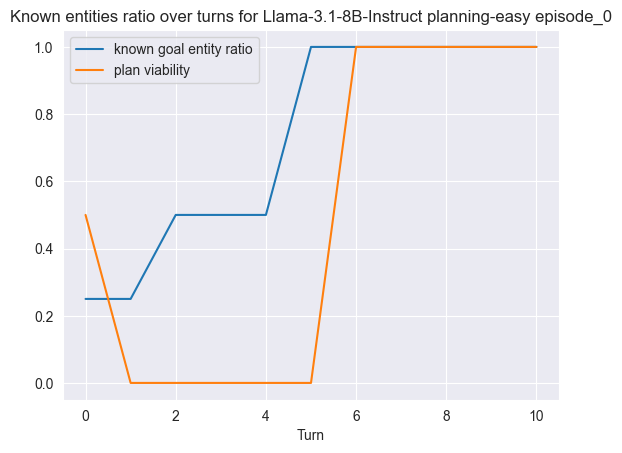

In [55]:
fig, ax = plt.subplots()

# ax.plot(turns_known_entities_ratio)
ax.plot(turns_known_goal_entities_ratio)
ax.plot(turns_plan_command_success_ratio)

ax.set(xlabel='Turn',
       title=f'Known entities ratio over turns for {model_name_dict[model_id]} {experiment_short_name_dict[variant]} {episode}')
# ax.grid()
ax.legend(['known goal entity ratio', 'plan viability'], loc='upper left')

# fig.savefig("test.png")
plt.show()

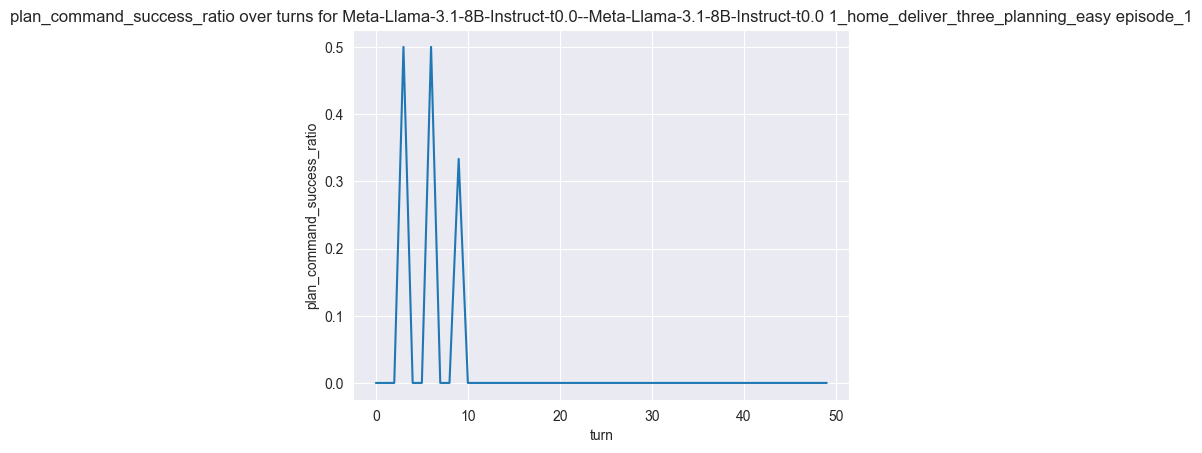

In [56]:
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "1_home_deliver_three_planning_easy"
episode = "episode_1"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
turn_scores = scores['turn scores']
turns_plan_command_success_ratio = [score_values['plan_command_success_ratio'] for score_values in turn_scores.values()]
# turns_plan_command_success_ratio

fig, ax = plt.subplots()

# ax.plot(turns_known_entities_ratio)
ax.plot(turns_plan_command_success_ratio)

ax.set(xlabel='turn', ylabel='plan_command_success_ratio',
       title=f'plan_command_success_ratio over turns for {model_id} {variant} {episode}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

In [57]:
def get_score_progress_list(model_id: str, variant: str, episode: str, score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    turn_scores = scores['turn scores']
    turns_score = [score_values[score] for score_values in turn_scores.values()]
    return turns_score

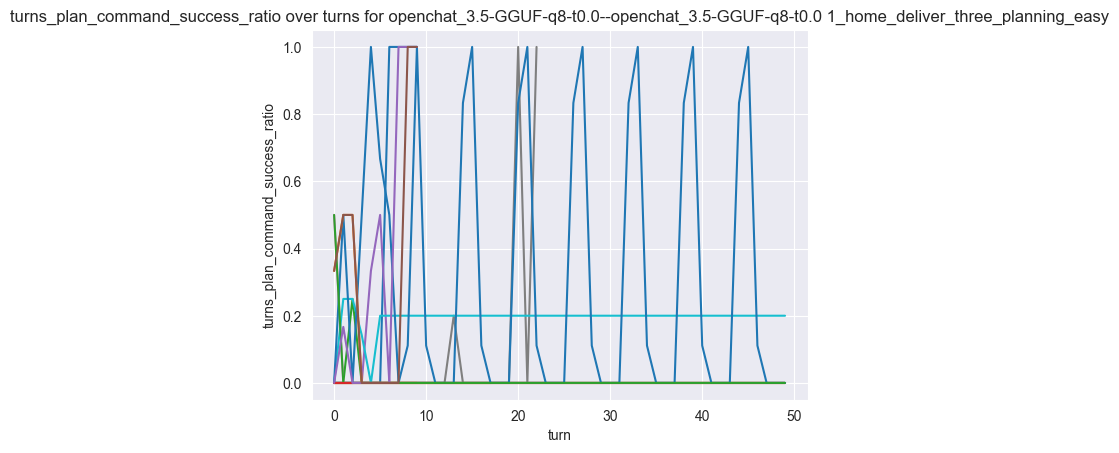

In [58]:
# model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
model_id = "openchat_3.5-GGUF-q8-t0.0--openchat_3.5-GGUF-q8-t0.0"
variant = "1_home_deliver_three_planning_easy"
episodes = [f"episode_{number}" for number in range(0,16)]

fig, ax = plt.subplots()

for episode in episodes:
    turns_plan_command_success_ratio = get_score_progress_list(model_id, variant, episode, "plan_command_success_ratio")
    ax.plot(turns_plan_command_success_ratio)

ax.set(xlabel='turn', ylabel='turns_plan_command_success_ratio',
       title=f'turns_plan_command_success_ratio over turns for {model_id} {variant}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

In [59]:
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "0_home_deliver_three_basic_easy"
episodes = [f"episode_{number}" for number in range(0,16)]

def get_exploration_progress_list(model_id: str, variant: str, episode: str, exploration_score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    turn_scores = scores['turn scores']
    turns_exploration_score = [score_values[exploration_score] for score_values in turn_scores.values()]
    return turns_exploration_score

get_exploration_progress_list(model_id, variant, episodes[0], "known_entities_ratio")

[0.13793103448275862,
 0.13793103448275862,
 0.1724137931034483,
 0.27586206896551724,
 0.27586206896551724,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552]

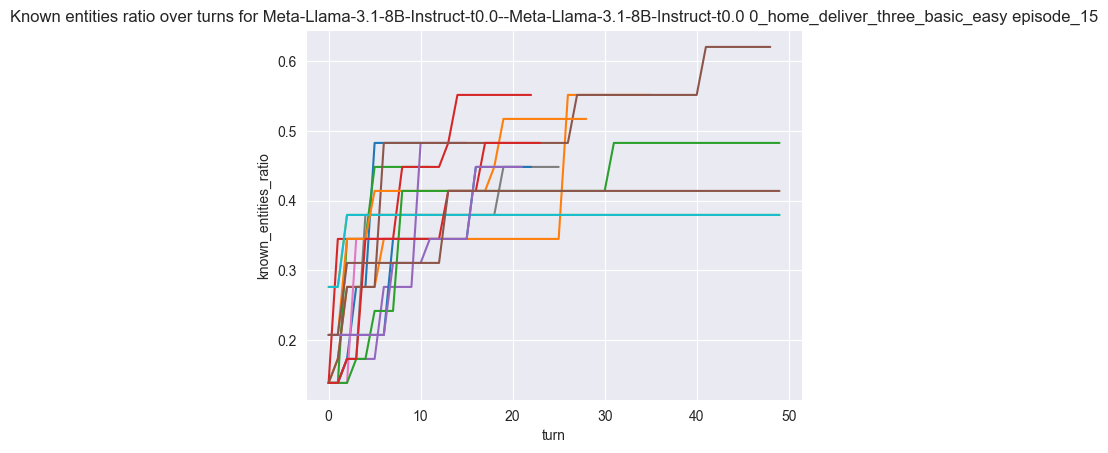

In [60]:
fig, ax = plt.subplots()

for episode in episodes:
    turns_known_entities_ratio = get_exploration_progress_list(model_id, variant, episode, "known_entities_ratio")
    ax.plot(turns_known_entities_ratio)

ax.set(xlabel='turn', ylabel='known_entities_ratio',
       title=f'Known entities ratio over turns for {model_id} {variant} {episode}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

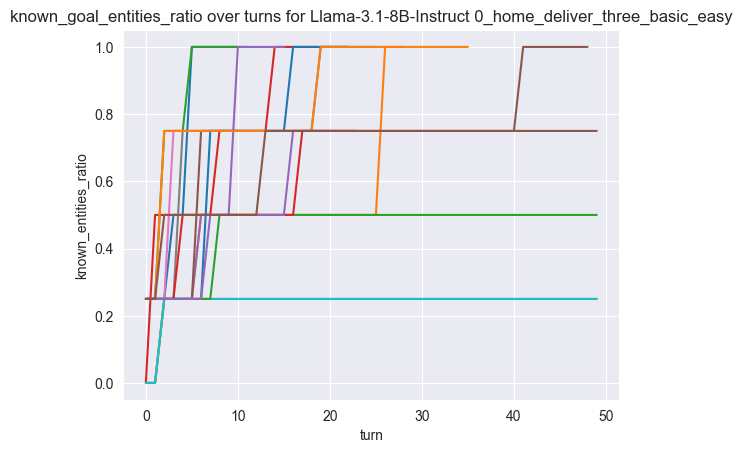

In [61]:
exploration_score = "known_goal_entities_ratio"

fig, ax = plt.subplots()

for episode in episodes:
    turns_known_entities_ratio = get_exploration_progress_list(model_id, variant, episode, exploration_score)
    ax.plot(turns_known_entities_ratio)

ax.set(xlabel='turn', ylabel='known_entities_ratio',
       title=f'{exploration_score} over turns for {model_name_dict[model_id]} {variant}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

## Epistemic/Pragmatic

In [62]:
# get single episode for exploration line plot
model_id = "openchat_3.5-GGUF-q8-t0.0--openchat_3.5-GGUF-q8-t0.0"
# variant = "0_home_deliver_three_basic_easy"
variant = "2_home_deliver_three_basic_easy_invlimittwo"
# episode = "episode_0"
episode = "episode_2"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
turn_scores = scores['turn scores']
turns_epistemic = [score_values['epistemic_action'] for score_values in turn_scores.values()]
turns_pragmatic = [score_values['pragmatic_action'] for score_values in turn_scores.values()]
turns_epistemic_gain = [score_values['effective_epistemic_gain_amount'] for score_values in turn_scores.values()]
turns_goal_score = [score_values['goal_score'] for score_values in turn_scores.values()]
turns_resolution_fail = [score_values['action_resolution_fail'] for score_values in turn_scores.values()]
turns_parsing_fail = [score_values['action_parsing_fail'] for score_values in turn_scores.values()]

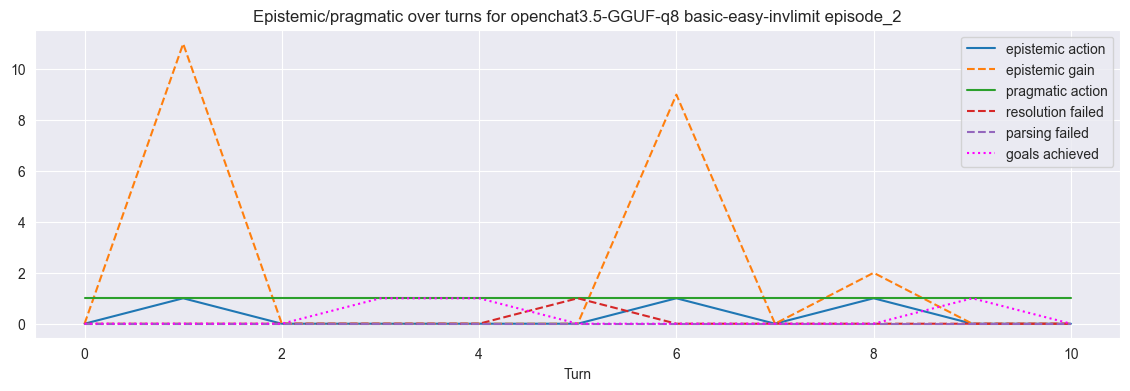

In [63]:
fig, ax = plt.subplots(figsize=(14, 4))

# ax.plot(turns_known_entities_ratio)
ax.plot(turns_epistemic)
ax.plot(turns_epistemic_gain, linestyle='dashed')
ax.plot(turns_pragmatic)
ax.plot(turns_resolution_fail, linestyle='dashed')
ax.plot(turns_parsing_fail, linestyle='dashed')
ax.plot(turns_goal_score, linestyle='dotted', color='magenta')

ax.set(xlabel='Turn',
       title=f'Epistemic/pragmatic over turns for {model_name_dict[model_id]} {experiment_short_name_dict[variant]} {episode}')
# ax.grid()
ax.legend(['epistemic action', 'epistemic gain', 'pragmatic action', 'resolution failed', 'parsing failed', 'goals achieved'], loc='upper right')

# fig.savefig("test.png")
plt.show()

### Average turns and epistemic/pragmatic actions

In [64]:
# get single episode for exploration line plot
model_id = "openchat_3.5-GGUF-q8-t0.0--openchat_3.5-GGUF-q8-t0.0"
# variant = "0_home_deliver_three_basic_easy"
variant = "2_home_deliver_three_basic_easy_invlimittwo"
# episode = "episode_0"
episode = "episode_2"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)

In [86]:
def get_score_over_episodes(model_id, variant, score):
    all_episodes = list()
    if os.path.exists(f"results/{model_id}"):
        for ep_num in range(0,16):
            episode = f"episode_{ep_num}"
            # print(variant, episode)
            episode_score_list = list()
            with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
                scores = json.load(scores_file)
                # print("scores:", scores)
                ep_turn_scores = scores['turn scores']
                for turn_number, turn_dict in ep_turn_scores.items():
                    # print("turn number:", turn_number)
                    # in some cases the score might be missing on the last turn:
                    if score in turn_dict:
                        episode_score_list.append(turn_dict[score])
                all_episodes.append(episode_score_list)
        return all_episodes
    else:
        return []


In [66]:
epistemic_action_counts = get_score_over_episodes(model_id, variant, "epistemic_action")

In [67]:
numbers_of_turns = [len(episode_turns) for episode_turns in epistemic_action_counts]
numbers_of_turns

[6, 50, 11, 50, 6, 17, 15, 50, 22, 50, 10, 20, 50, 50, 15, 20]

In [68]:
numbers_of_epistemic_actions = [sum(episode_turns) for episode_turns in epistemic_action_counts]
numbers_of_epistemic_actions

[1, 14, 3, 13, 1, 8, 6, 30, 4, 21, 3, 7, 29, 12, 6, 7]

In [69]:
average_number_of_turns = np.average(numbers_of_turns)
average_number_of_turns

np.float64(27.625)

In [70]:
average_number_of_epistemic_actions = np.average(numbers_of_epistemic_actions)
average_number_of_epistemic_actions

np.float64(10.3125)

In [71]:
def get_average_score_over_experiments(model_id, score):
    variant_turns_average = list()
    variant_score_averages = list()
    for variant in experiment_short_name_dict.keys():
        variant_scores = get_score_over_episodes(model_id, variant, score)
        numbers_of_turns = [len(episode_turns) for episode_turns in variant_scores]
        numbers_of_scores = [sum(episode_turns) for episode_turns in variant_scores]
        average_number_of_turns = np.average(numbers_of_turns)
        variant_turns_average.append(average_number_of_turns)
        average_number_of_scores = np.average(numbers_of_scores)
        variant_score_averages.append(average_number_of_scores)
    return variant_turns_average, variant_score_averages


In [72]:
get_average_score_over_experiments(model_id, "epistemic_action")

([np.float64(30.875),
  np.float64(31.875),
  np.float64(27.625),
  np.float64(36.75),
  np.float64(38.25),
  np.float64(34.3125),
  np.float64(40.3125),
  np.float64(39.125)],
 [np.float64(10.625),
  np.float64(12.9375),
  np.float64(10.3125),
  np.float64(14.75),
  np.float64(20.5625),
  np.float64(20.25),
  np.float64(19.6875),
  np.float64(17.8125)])

In [73]:
get_average_score_over_experiments("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", "epistemic_action")

([np.float64(15.125),
  np.float64(16.125),
  np.float64(18.3125),
  np.float64(17.3125),
  np.float64(29.125),
  np.float64(31.25),
  np.float64(32.0625),
  np.float64(29.8125)],
 [np.float64(8.0),
  np.float64(8.5625),
  np.float64(9.625),
  np.float64(8.25),
  np.float64(19.625),
  np.float64(22.1875),
  np.float64(20.8125),
  np.float64(19.3125)])

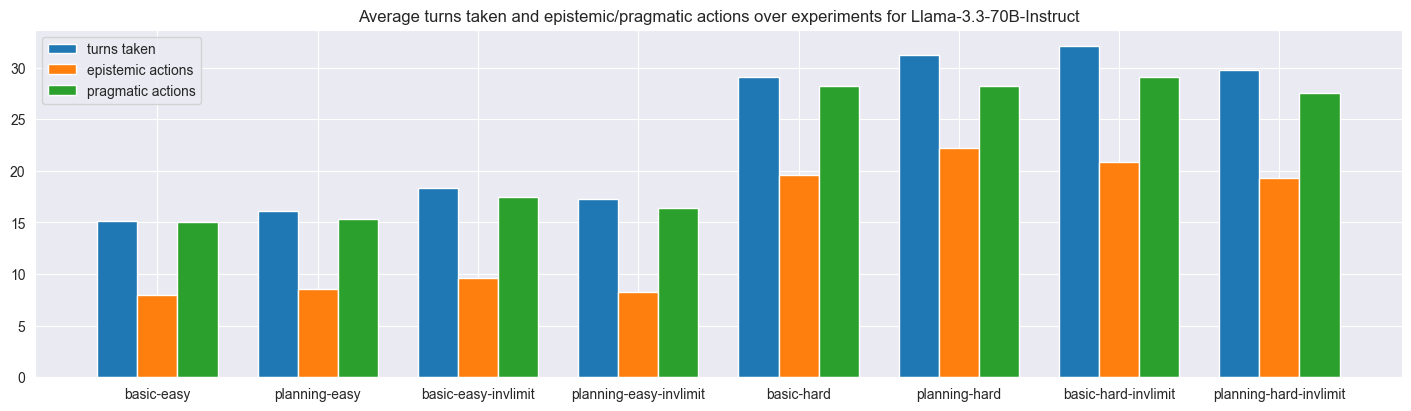

In [74]:
model_id = "Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0"
avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "epistemic_action")
avg_turns = avg_epistemic_scores_tuple[0]
avg_epistemic_actions = avg_epistemic_scores_tuple[1]
avg_pragmatic_scores_tuple = get_average_score_over_experiments(model_id, "pragmatic_action")
avg_pragmatic_actions = avg_pragmatic_scores_tuple[1]

# variants_short = [experiment_short_name_dict[variant_long] for variant_long in variants]
variants_short = experiment_short_name_dict.values()

fig, ax = plt.subplots(figsize=(14, 4), layout='constrained')

barWidth = 0.25
br1 = np.arange(len(avg_turns))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

ax.bar(br1, avg_turns, width=barWidth, label="turns taken")
ax.bar(br2, avg_epistemic_actions, width=barWidth, label="epistemic actions")
ax.bar(br3, avg_pragmatic_actions, width=barWidth, label="pragmatic actions")


# ax.bar(variants_short, avg_turns, label="turns")
# ax.bar(variants_short, avg_epistemic_actions, label="epistemic actions")

# plt.bar(variants_short, avg_turns, width=0.25)
# plt.bar(variants_short, avg_epistemic_actions, width=0.25)


ax.set(title=f'Average turns taken and epistemic/pragmatic actions over experiments for {model_name_dict[model_id]}')

plt.xticks([r + barWidth for r in range(len(avg_turns))], variants_short)

# ax.grid()

plt.legend()

# fig.savefig("test.png")
plt.show()

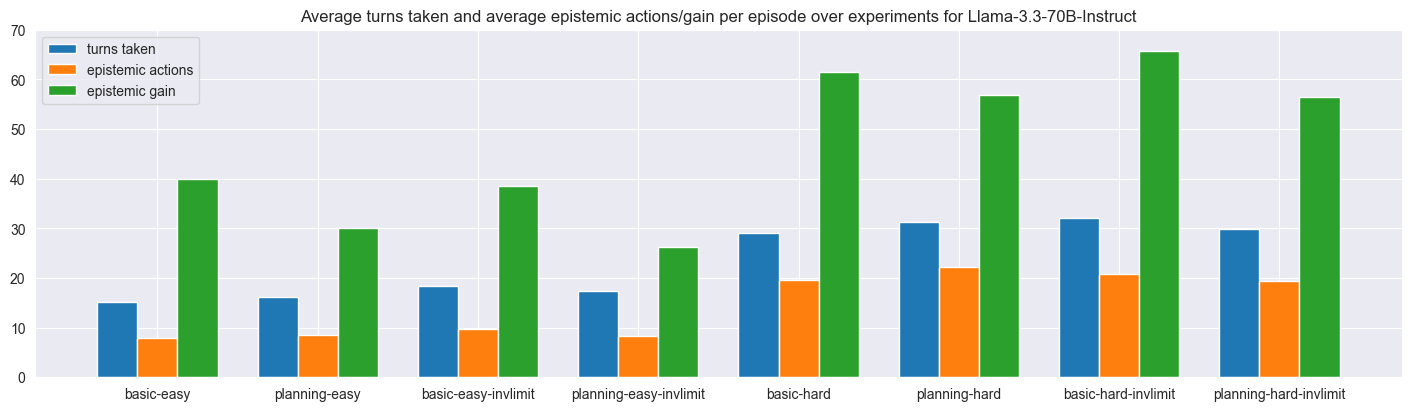

In [75]:
model_id = "Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0"
avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "effective_epistemic_gain_amount")
avg_turns = avg_epistemic_scores_tuple[0]
avg_epistemic_gain = avg_epistemic_scores_tuple[1]
avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "epistemic_action")
avg_epistemic_actions = avg_epistemic_scores_tuple[1]

# avg_pragmatic_scores_tuple = get_average_score_over_experiments(model_id, "pragmatic_action")
# avg_pragmatic_actions = avg_pragmatic_scores_tuple[1]

# variants_short = [experiment_short_name_dict[variant_long] for variant_long in variants]
variants_short = experiment_short_name_dict.values()

fig, ax = plt.subplots(figsize=(14, 4), layout='constrained')

barWidth = 0.25
br1 = np.arange(len(avg_turns))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

ax.bar(br1, avg_turns, width=barWidth, label="turns taken")
ax.bar(br2, avg_epistemic_actions, width=barWidth, label="epistemic actions")
ax.bar(br3, avg_epistemic_gain, width=barWidth, label="epistemic gain")

# ax.bar(variants_short, avg_turns, label="turns")
# ax.bar(variants_short, avg_epistemic_actions, label="epistemic actions")

# plt.bar(variants_short, avg_turns, width=0.25)
# plt.bar(variants_short, avg_epistemic_actions, width=0.25)


ax.set(title=f'Average turns taken and average epistemic actions/gain per episode over experiments for {model_name_dict[model_id]}')

plt.xticks([r + barWidth for r in range(len(avg_turns))], variants_short)

# ax.grid()

plt.ylim(0, 70)

plt.legend()

# fig.savefig("test.png")
plt.show()

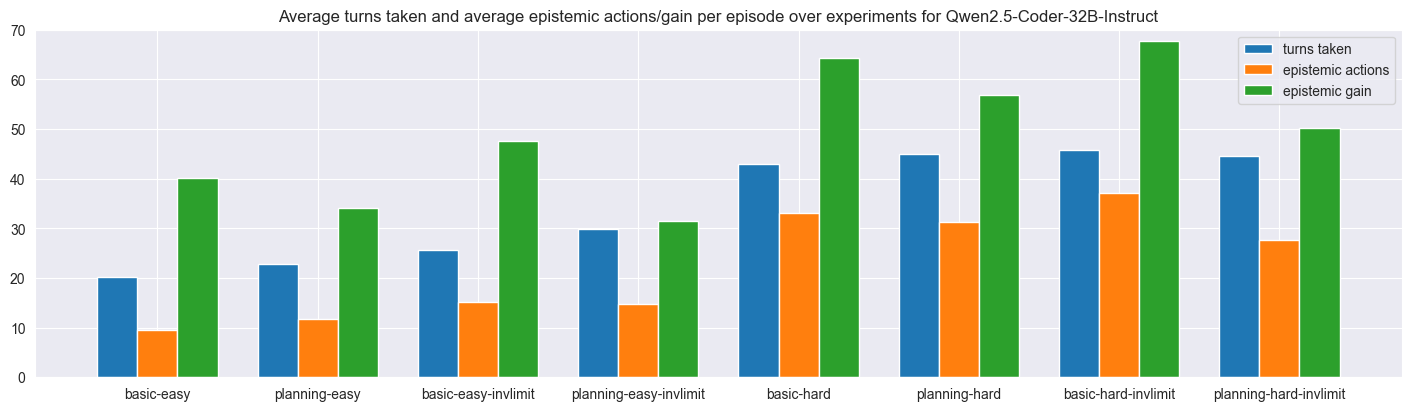

In [76]:
model_id = "Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0"
avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "effective_epistemic_gain_amount")
avg_turns = avg_epistemic_scores_tuple[0]
avg_epistemic_gain = avg_epistemic_scores_tuple[1]
avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "epistemic_action")
avg_epistemic_actions = avg_epistemic_scores_tuple[1]

# avg_pragmatic_scores_tuple = get_average_score_over_experiments(model_id, "pragmatic_action")
# avg_pragmatic_actions = avg_pragmatic_scores_tuple[1]

# variants_short = [experiment_short_name_dict[variant_long] for variant_long in variants]
variants_short = experiment_short_name_dict.values()

fig, ax = plt.subplots(figsize=(14, 4), layout='constrained')

barWidth = 0.25
br1 = np.arange(len(avg_turns))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

ax.bar(br1, avg_turns, width=barWidth, label="turns taken")
ax.bar(br2, avg_epistemic_actions, width=barWidth, label="epistemic actions")
ax.bar(br3, avg_epistemic_gain, width=barWidth, label="epistemic gain")

# ax.bar(variants_short, avg_turns, label="turns")
# ax.bar(variants_short, avg_epistemic_actions, label="epistemic actions")

# plt.bar(variants_short, avg_turns, width=0.25)
# plt.bar(variants_short, avg_epistemic_actions, width=0.25)


ax.set(title=f'Average turns taken and average epistemic actions/gain per episode over experiments for {model_name_dict[model_id]}')

plt.xticks([r + barWidth for r in range(len(avg_turns))], variants_short)

plt.ylim(0, 70)

# ax.grid()

plt.legend()

# fig.savefig("test.png")
plt.show()

avg_turns [np.float64(31.6875), np.float64(24.4375), np.float64(19.4375), np.float64(29.625), np.float64(43.875), np.float64(40.4375), np.float64(41.3125), np.float64(39.875)]


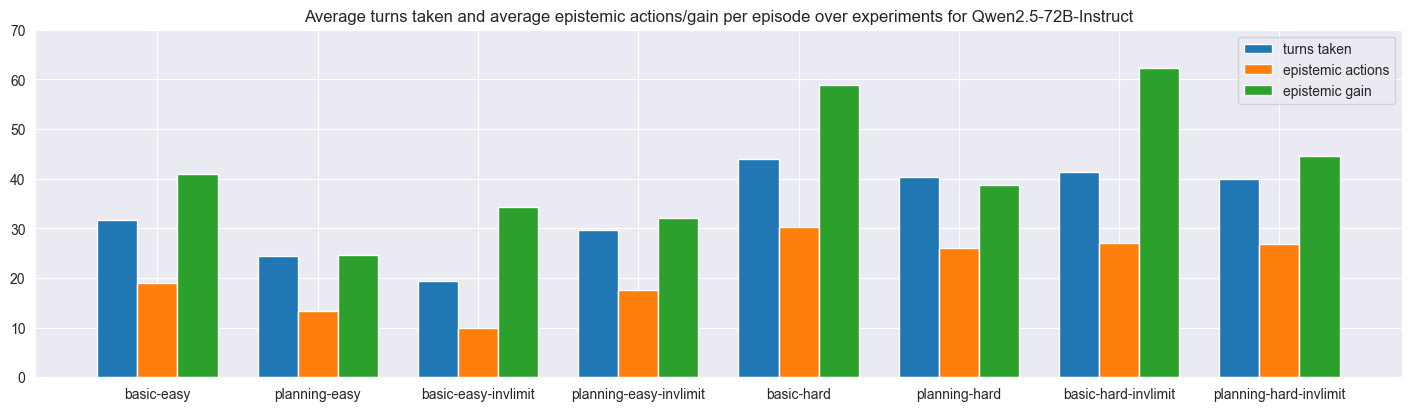

In [116]:
model_id = "Qwen2.5-72B-Instruct-t0.0--Qwen2.5-72B-Instruct-t0.0"
avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "effective_epistemic_gain_amount")
avg_turns = avg_epistemic_scores_tuple[0]
# print("avg_turns", avg_turns)
avg_epistemic_gain = avg_epistemic_scores_tuple[1]
avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "epistemic_action")
avg_epistemic_actions = avg_epistemic_scores_tuple[1]

# avg_pragmatic_scores_tuple = get_average_score_over_experiments(model_id, "pragmatic_action")
# avg_pragmatic_actions = avg_pragmatic_scores_tuple[1]

# variants_short = [experiment_short_name_dict[variant_long] for variant_long in variants]
variants_short = experiment_short_name_dict.values()

fig, ax = plt.subplots(figsize=(14, 4), layout='constrained')

barWidth = 0.25
br1 = np.arange(len(avg_turns))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

ax.bar(br1, avg_turns, width=barWidth, label="turns taken")
ax.bar(br2, avg_epistemic_actions, width=barWidth, label="epistemic actions")
ax.bar(br3, avg_epistemic_gain, width=barWidth, label="epistemic gain")

# ax.bar(variants_short, avg_turns, label="turns")
# ax.bar(variants_short, avg_epistemic_actions, label="epistemic actions")

# plt.bar(variants_short, avg_turns, width=0.25)
# plt.bar(variants_short, avg_epistemic_actions, width=0.25)


ax.set(title=f'Average turns taken and average epistemic actions/gain per episode over experiments for {model_name_dict[model_id]}')

plt.xticks([r + barWidth for r in range(len(avg_turns))], variants_short)

plt.ylim(0, 70)

# ax.grid()

plt.legend()

# fig.savefig("test.png")
plt.show()

ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (20).

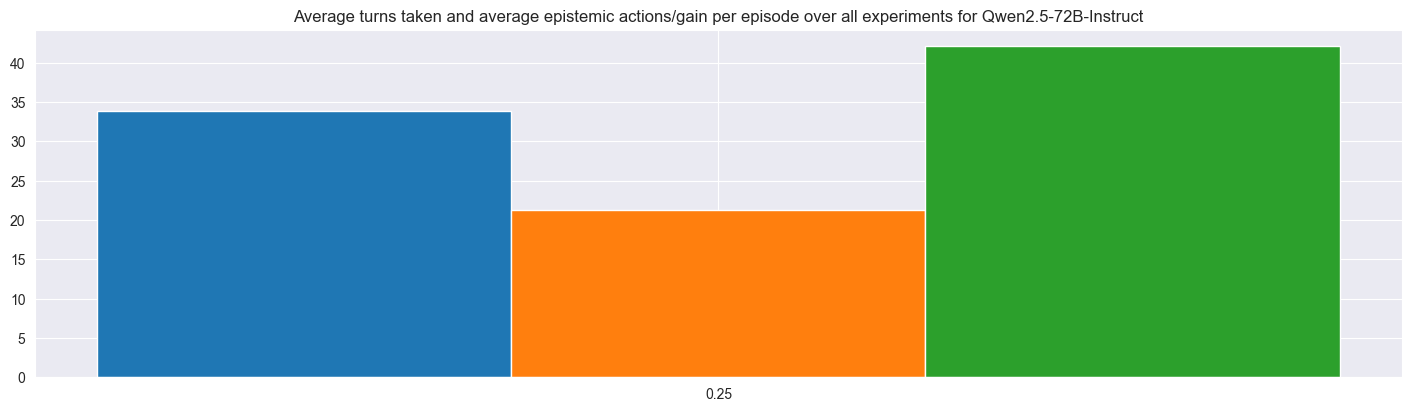

In [122]:
model_id = "Qwen2.5-72B-Instruct-t0.0--Qwen2.5-72B-Instruct-t0.0"
avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "effective_epistemic_gain_amount")
avg_turns = avg_epistemic_scores_tuple[0]
avg_turns_overall = np.average(avg_epistemic_scores_tuple[0])
avg_epistemic_gain = avg_epistemic_scores_tuple[1]
avg_epistemic_gain_overall = np.average(avg_epistemic_scores_tuple[1])
avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "epistemic_action")
avg_epistemic_actions = avg_epistemic_scores_tuple[1]
avg_epistemic_actions_overall = np.average(avg_epistemic_scores_tuple[1])

# avg_pragmatic_scores_tuple = get_average_score_over_experiments(model_id, "pragmatic_action")
# avg_pragmatic_actions = avg_pragmatic_scores_tuple[1]

# variants_short = [experiment_short_name_dict[variant_long] for variant_long in variants]
variants_short = experiment_short_name_dict.values()

fig, ax = plt.subplots(figsize=(14, 4), layout='constrained')

barWidth = 0.25
# br1 = np.arange(len(avg_turns))
br1 = np.arange(1)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

ax.bar(br1, avg_turns_overall, width=barWidth, label="turns taken")
ax.bar(br2, avg_epistemic_actions_overall, width=barWidth, label="epistemic actions")
ax.bar(br3, avg_epistemic_gain_overall, width=barWidth, label="epistemic gain")

# ax.bar(variants_short, avg_turns, label="turns")
# ax.bar(variants_short, avg_epistemic_actions, label="epistemic actions")

# plt.bar(variants_short, avg_turns, width=0.25)
# plt.bar(variants_short, avg_epistemic_actions, width=0.25)


ax.set(title=f'Average turns taken and average epistemic actions/gain per episode over all experiments for {model_name_dict[model_id]}')

# plt.xticks([r + barWidth for r in range(len(avg_turns))], model_name_dict[model_id])
plt.xticks([r + barWidth for r in range(1)], model_name_dict[model_id])

plt.ylim(0, 70)

# ax.grid()

plt.legend()

# fig.savefig("test.png")
plt.show()

In [134]:
# get averages for all models
def get_average_epistemic_all():
    avg_turns_list = list()
    avg_epistemic_gain_list = list()
    avg_epistemic_actions_list = list()
    avg_plan_viability_list = list()
    for model_id in model_name_dict:
        avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "effective_epistemic_gain_amount")
        avg_turns = avg_epistemic_scores_tuple[0]
        # print("avg_turns", avg_turns)
        avg_turns_overall = np.average(avg_epistemic_scores_tuple[0])
        # print("avg_turns_overall", avg_turns_overall)
        if not np.isnan(avg_turns_overall):
            avg_turns_list.append(avg_turns_overall)
        avg_epistemic_gain = avg_epistemic_scores_tuple[1]
        avg_epistemic_gain_overall = np.average(avg_epistemic_scores_tuple[1])
        if not np.isnan(avg_epistemic_gain_overall):
            avg_epistemic_gain_list.append(avg_epistemic_gain_overall)
        avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "epistemic_action")
        avg_epistemic_actions = avg_epistemic_scores_tuple[1]
        avg_epistemic_actions_overall = np.average(avg_epistemic_scores_tuple[1])
        if not np.isnan(avg_epistemic_actions_overall):
            avg_epistemic_actions_list.append(avg_epistemic_actions_overall)
        avg_plan_viability_tuple = get_average_score_over_experiments(model_id, "plan_command_success_ratio")
        avg_plan_viability = avg_plan_viability_tuple[1]
        avg_plan_viability_overall = np.average(avg_plan_viability_tuple[1])
        if not np.isnan(avg_plan_viability_overall):
            avg_plan_viability_list.append(avg_plan_viability_overall)
    return avg_turns_list, avg_epistemic_gain_list, avg_epistemic_actions_list, avg_plan_viability_list

In [135]:
avg_turns_list, avg_epistemic_gain_list, avg_epistemic_actions_list, avg_plan_viability_list = get_average_epistemic_all()
print(avg_turns_list)
print(avg_epistemic_gain_list)
print(avg_epistemic_actions_list)
print(avg_plan_viability_list)

[np.float64(34.890625), np.float64(33.4921875), np.float64(33.3125), np.float64(38.3203125), np.float64(20.9609375), np.float64(44.5625), np.float64(34.578125), np.float64(43.28125), np.float64(33.8359375), np.float64(23.640625), np.float64(23.2421875), np.float64(44.375)]
[np.float64(32.2578125), np.float64(30.7734375), np.float64(44.890625), np.float64(47.3359375), np.float64(27.3515625), np.float64(50.9375), np.float64(49.0546875), np.float64(35.40625), np.float64(42.0625), np.float64(46.921875), np.float64(45.6953125), np.float64(47.484375)]
[np.float64(15.8671875), np.float64(16.828125), np.float64(17.0078125), np.float64(21.421875), np.float64(9.78125), np.float64(28.578125), np.float64(22.5703125), np.float64(22.9609375), np.float64(21.2109375), np.float64(14.546875), np.float64(14.1015625), np.float64(21.078125)]
[np.float64(1.719835351280664), np.float64(1.8059653454184703), np.float64(0.5206747298163223), np.float64(2.803125), np.float64(0.517578125), np.float64(2.53001302083

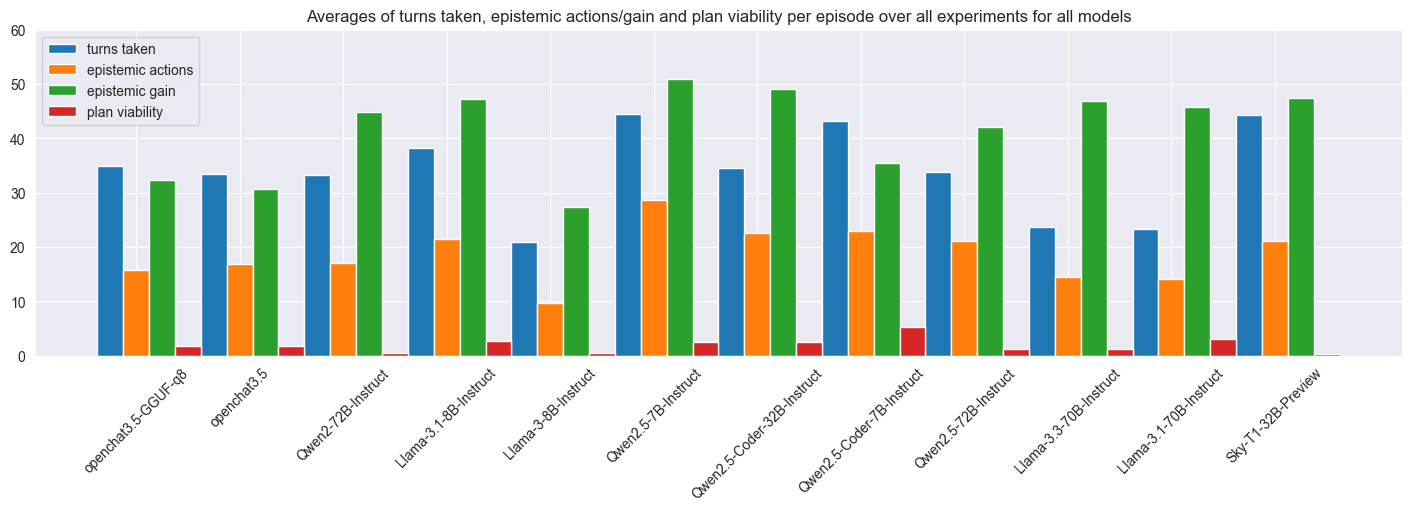

In [144]:
# print("avg_turns_list", avg_turns_list)

fig, ax = plt.subplots(figsize=(14, 5), layout='constrained')

barWidth = 0.25
br1 = np.arange(len(avg_turns_list))
# br1 = np.arange(1)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

# ax.bar(br1, avg_plan_viability_list, width=barWidth, label="plan viability")


ax.bar(br1, avg_turns_list, width=barWidth, label="turns taken")
ax.bar(br2, avg_epistemic_actions_list, width=barWidth, label="epistemic actions")
ax.bar(br3, avg_epistemic_gain_list, width=barWidth, label="epistemic gain")
ax.bar(br4, avg_plan_viability_list, width=barWidth, label="plan viability")

# ax.bar(variants_short, avg_turns, label="turns")
# ax.bar(variants_short, avg_epistemic_actions, label="epistemic actions")

# plt.bar(variants_short, avg_turns, width=0.25)
# plt.bar(variants_short, avg_epistemic_actions, width=0.25)


ax.set(title=f'Averages of turns taken, epistemic actions/gain and plan viability per episode over all experiments for all models')

# plt.xticks([r + barWidth for r in range(len(avg_turns))], model_name_dict[model_id])
plt.xticks([r + barWidth for r in range(len(avg_turns_list))], model_name_dict.values(), rotation=45)

plt.ylim(0, 60)

# ax.grid()

plt.legend()

# fig.savefig("test.png")
plt.show()

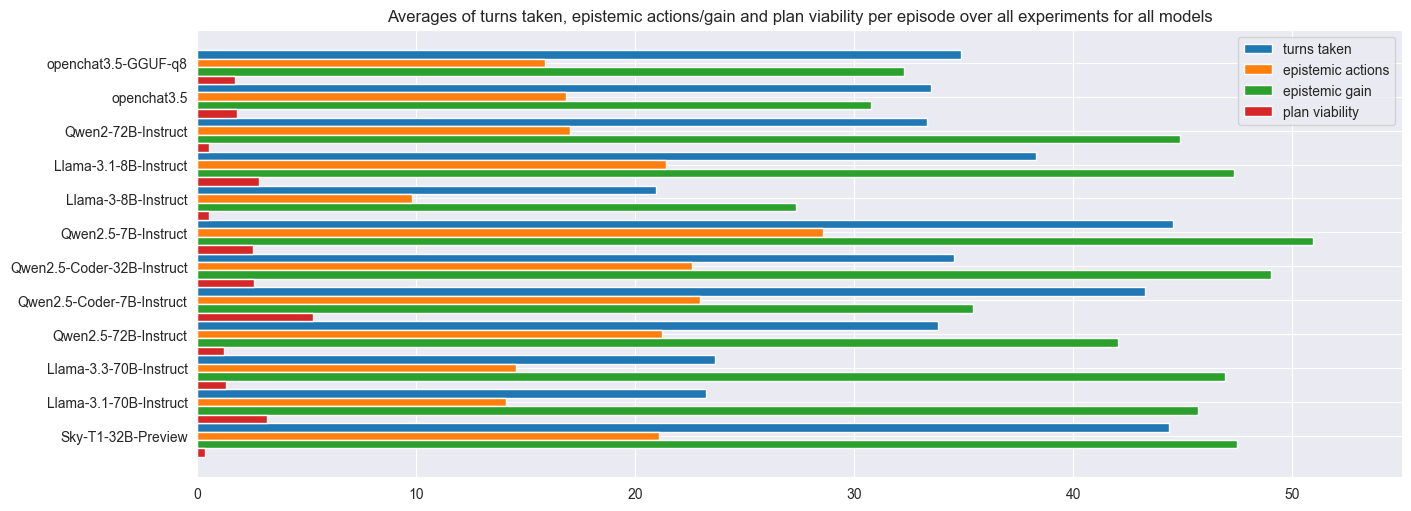

In [164]:
fig, ax = plt.subplots(figsize=(14, 5), layout='constrained')

barWidth = 0.25
br1 = np.arange(len(avg_turns_list))
# br1 = np.arange(1)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

# ax.bar(br1, avg_plan_viability_list, width=barWidth, label="plan viability")


ax.barh(br1, avg_turns_list, height=barWidth, label="turns taken")

ax.barh(br2, avg_epistemic_actions_list, height=barWidth, label="epistemic actions")
ax.barh(br3, avg_epistemic_gain_list, height=barWidth, label="epistemic gain")
ax.barh(br4, avg_plan_viability_list, height=barWidth, label="plan viability")


# ax.bar(variants_short, avg_turns, label="turns")
# ax.bar(variants_short, avg_epistemic_actions, label="epistemic actions")

# plt.bar(variants_short, avg_turns, width=0.25)
# plt.bar(variants_short, avg_epistemic_actions, width=0.25)

ax.invert_yaxis()

ax.set(title=f'Averages of turns taken, epistemic actions/gain and plan viability per episode over all experiments for all models')

# plt.xticks([r + barWidth for r in range(len(avg_turns))], model_name_dict[model_id])
# plt.xticks([r + barWidth for r in range(len(avg_turns_list))], model_name_dict.values(), rotation=45)
plt.yticks([r + barWidth for r in range(len(avg_turns_list))], model_name_dict.values())

plt.xlim(0, 55)

# ax.grid()

plt.legend()

# fig.savefig("test.png")
plt.show()